Ndet: 809
Time: 0.0022306442260742188


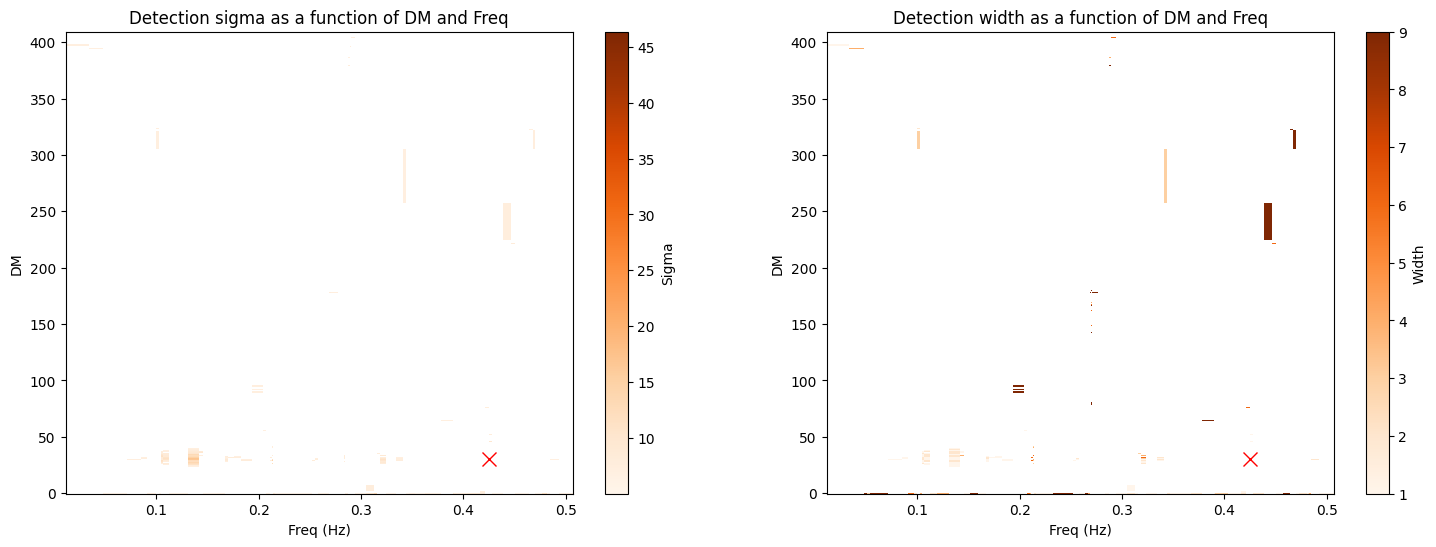

(29.9545882, 0.42520247, 46.35430908, 2)
[1 2 3 4 6 9]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools

detections_dtype = [
    ("dm", float),
    ("freq", float),
    ("sigma", float),
    ("width", int)
]

ra = 29.37
dec = 62.12
# ra = 301.12
# dec = 31.53
# ra = 160.01
# dec = 50.21
file_path = f"detections/2024/6/10/{ra}_{dec}_FFA_detections.npz"

loaded = np.load(file_path, allow_pickle=True)
detections = loaded["detections"]
n_det = len(detections)
print("Ndet:",n_det)
detections = np.array([detection for detection in detections if detection['sigma'] >= 5])

dm_values = np.array([det['dm'] for det in detections])
freq_values = np.array([det['freq'] for det in detections])
sigma_values = np.array([det['sigma'] for det in detections])
width_values = np.array([det['width'] for det in detections])
widths = np.array([1,2,3,4,6,9])

nb_width_values = []
start_time = time.time()
tmp = [
    [k, detections[k]['freq'], detections[k]['dm'], detections[k]['sigma']] for k in range(n_det)
]
st = sorted(tmp, key=lambda st: (st[1], st[2], st[3]))
nb_width_values = [
        len(list(value)) for k, value in itertools.groupby(st, key=lambda st: (st[1], st[2]))
    ]

print("Time:",time.time()-start_time)    

dm_unique = np.unique(dm_values)
freq_unique = np.unique(freq_values)
freq_grid, dm_grid = np.meshgrid(freq_unique, dm_unique)

sigma_grid = np.zeros_like(freq_grid, dtype=float)
width_grid = np.zeros_like(freq_grid, dtype=int)
for i, (dm, freq, sigma, width) in enumerate(zip(dm_values, freq_values, sigma_values, width_values)):
    col = np.where(freq_unique == freq)[0][0]
    row = np.where(dm_unique == dm)[0][0]
    sigma_grid[row, col] = sigma
    width_grid[row, col] = width

# log_sigma_grid = np.log(sigma_grid + 1e-1)
masked_sigma_grid = np.ma.masked_where(sigma_grid == 0, sigma_grid)
masked_width_grid = np.ma.masked_where(width_grid == 0, width_grid)
cmap = plt.cm.Oranges
cmap.set_bad(color='white')

max_id = np.argmax(sigma_values)
max_dm = detections[max_id]['dm']
max_freq = detections[max_id]['freq']

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
heatmap = axs[0].pcolormesh(freq_grid, dm_grid, masked_sigma_grid, shading='auto', cmap=cmap)
plt.colorbar(heatmap, label='Sigma')
axs[0].plot(max_freq, max_dm, 'rx', markersize=10, label='Max Sigma')
axs[0].set_xlabel('Freq (Hz)')
axs[0].set_ylabel('DM')
axs[0].set_title('Detection sigma as a function of DM and Freq')

heatmap = axs[1].pcolormesh(freq_grid, dm_grid, masked_width_grid, shading='auto', cmap=cmap)
plt.colorbar(heatmap, label='Width')
axs[1].plot(max_freq, max_dm, 'rx', markersize=10, label='Max Sigma')
axs[1].set_xlabel('Freq (Hz)')
axs[1].set_ylabel('DM')
axs[1].set_title('Detection width as a function of DM and Freq')
plt.show()
print(detections[max_id])
print(np.unique(width_values))

In [2]:
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import paired_distances
from sklearn.neighbors import radius_neighbors_graph, sort_graph_by_row_values

cluster_dm_spacing = 1
dm_scale_factor = 1
cluster_df_spacing = 1
freq_scale_factor = 300
cluster_dm_cut = 10

dbscan_eps = 1
dbscan_min_samples = 5

start_time = time.time()


data_filter = np.vstack(
    (
        detections["dm"]
        / cluster_dm_spacing
        * dm_scale_factor,
        detections["freq"]
        / cluster_df_spacing
        * freq_scale_factor,
    ),
    dtype=np.float32,
).T
metric_array = radius_neighbors_graph(
    data_filter, 1.1 * dbscan_eps, p=2, mode="distance"
)
metric_array = sort_graph_by_row_values(
    metric_array, warn_when_not_sorted=False
)
db_filter = DBSCAN(
    eps=dbscan_eps,
    min_samples=dbscan_min_samples,
    metric="precomputed",
).fit(metric_array)

labels = db_filter.labels_
print(time.time()-start_time)
print(labels)

0.06612920761108398
[-1 -1  0  0 -1 -1 -1  1 -1 -1  1  2 -1  2  0  2  2  1 -1 -1  0 -1 -1 -1
 -1  1 -1 -1  1 -1 -1 -1  0 -1  3  4 -1 -1  2  4 -1  4 -1 -1 -1  0  0 -1
  4 -1 -1 -1  3  3 -1 -1  4  3 -1  1 -1 -1 -1 -1 -1  3 -1 -1 -1  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  6  6 -1  5  5  5 -1  6  6 -1  5  5
  5  5  6  6 -1 -1  5  5  6 -1  7  6  7  5  5  5  6  8  6  7 -1  8  5  5
  5  6  8  7  6  7 10  9  9  9 10  5  5  5  6  8  7  7  6  8 10  9  9  8
  5  5  6  6  8  7  7 10  9  9  9  8 10 -1  5  5  6  7  8  6  7 10  9  9
 -1 -1 -1 10 -1  6  5  5  5  6  6 11  7  7  6  9 10  9 12 10 -1 -1 -1 -1
 -1  5  5  5  6 11  7 11  7 10  9  9 10 12 -1  6 11 -1 12 -1 -1  9  5  5
  6 11  7  7 10  9 10 12 11  6 -1  9 -1 12 -1  5  5  5  6  6 11  7  7 10
  9  9 10 11 12 -1  5  5  5  6  6 11  7  7 10  9  9  9 10 11  6  7  5  6
  6 11  7  7 10  9  9 10 11  5  5  6  6 11  7 11  7 10  9  9 10  6  5  5
  5  6  6 11 11  7  7 10 10  9 

In [3]:
filtered_indices = []
bad_freqs = []
filtered_labels = []
for i in range(max(db_filter.labels_) + 1):
    current_indices = np.arange(detections.shape[0])[
        db_filter.labels_ == i
    ]
    det_sample = detections[current_indices]
    det_max_sigma_pos = np.argmax(det_sample["sigma"])
    det_max_sigma_dm = det_sample["dm"][det_max_sigma_pos]
    if det_max_sigma_dm <= cluster_dm_cut:
        filtered_indices.extend(current_indices)
        bad_freqs.append(
            (
                det_sample["freq"].mean(),
                det_sample["freq"].min(),
                det_sample["freq"].max(),
            )
        )
        filtered_labels.append(i)
bad_freqs = np.asarray(bad_freqs)
bad_low_dm_freqs = len(filtered_indices)
print(
    f"Dbscan filter removed {bad_low_dm_freqs} detections in low DM"
    " clusters."
)
print("Bad freqs:", bad_freqs)

Dbscan filter removed 28 detections in low DM clusters.
Bad freqs: [[0.48192657 0.48076349 0.48250357]
 [0.21568963 0.21552331 0.2158759 ]
 [0.09649807 0.09648291 0.0965145 ]
 [0.47273336 0.4727069  0.47276359]
 [0.26675726 0.26671154 0.26678974]]


In [4]:
dbscan_filter_whole_freqs = False

if dbscan_filter_whole_freqs:
    for i in range(max(db_filter.labels_) + 1):
        if i not in filtered_labels:
            current_indices = np.arange(detections.shape[0])[
                labels == i
            ]
            det_sample = detections[current_indices]
            mean_freq = det_sample["freq"].mean()
            for row in bad_freqs:
                if mean_freq > row[1] and mean_freq < row[2]:
                    filtered_indices.extend(current_indices)
                    break
    bad_all_freqs = len(filtered_indices)
    print(
        "Dbscan filter removed additonal"
        f" {bad_all_freqs - bad_low_dm_freqs} detections with same"
        " frequencies as low DM clusters."
    )

mask = np.full(detections.shape[0], True)
mask[filtered_indices] = False
detections = detections[mask]
labels = labels[mask]

mask = np.where(labels != -1)[0]
detections = detections[mask]
labels = labels[mask]

In [5]:
sigma_detection_threshold = 5
max_ndetect = 50000

detections = detections[
    detections["sigma"] > sigma_detection_threshold
]

# thin down detections if there are too many
print(
    "Number of detections over threshold sigma"
    f" ({sigma_detection_threshold}): {len(detections)}"
)
sig_limit = sigma_detection_threshold
if len(detections) > max_ndetect:
    print(
        f"The number of detections {len(detections)} is greater than the max"
        f" for the usual clustering scheme {max_ndetect}"
    )
    sig_limit = sigma_detection_threshold + 1
    selection = np.where(detections["sigma"] > sig_limit)[0]
    while len(selection) > max_ndetect:
        sig_limit += 0.2
        selection = np.where(detections["sigma"] > sig_limit)[0]
    detections = detections[selection]
    print(
        f"The minimum sigma has been raised to {sig_limit} to reduce the number"
        f" of detections to {len(detections)}"
    )



Number of detections over threshold sigma (5): 630


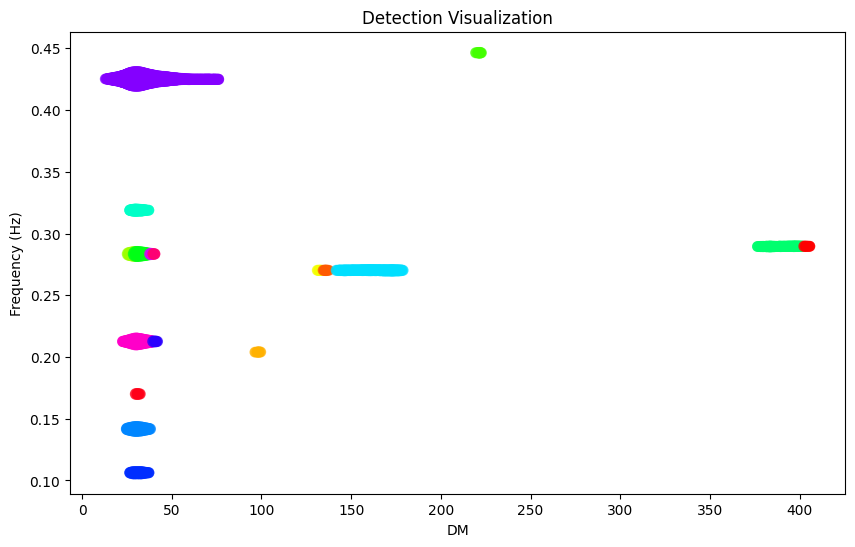

Unique groups: 18


In [7]:
# Generate a mapping of current labels to random unique integers to switch up the colours
unique_labels = np.unique(labels)
shuffled_labels = np.random.permutation(unique_labels)

# Create a dictionary for remapping
label_mapping = {old: new for old, new in zip(unique_labels, shuffled_labels)}

# Apply the mapping to the labels array
labels = np.array([label_mapping[label] for label in labels])

# Normalize sigma for scaling circle size
if len(detections) > 0:
    sigma_normalized = detections["sigma"] / detections["sigma"].max()
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    
    # Use a colormap for the labels
    cmap = plt.cm.hsv
    scatter = plt.scatter(
        detections["dm"], 
        detections["freq"], 
        c=labels, 
        s=sigma_normalized * 300,  # Scale the sizes (adjust multiplier as needed)
        cmap=cmap, 
        alpha=0.7
    )
    
    # Add color bar to indicate the group labels
    # cbar = plt.colorbar(scatter, ticks=range(-1, 300,10))
    # cbar.set_label('Group Labels')
    
    # Label the axes
    plt.xlabel("DM")
    plt.ylabel("Frequency (Hz)")
    plt.title("Detection Visualization")
    
    # Show the plot
    plt.show()
    print(f"Unique groups: {len(unique_labels)}")

In [60]:
import csv

csv_detections = [
    {
        "": i,
        "mean_freq": det['freq'],
        "mean_dm": det['dm'],
        "sigma": det['sigma'],
        "ra": ra,
        "dec": dec,
        "best_ra": ra,
        "best_dec": dec,
        "ncands": 1,
        "std_ra": 0,
        "std_dec": 0,
        "delta_ra": 0,
        "delta_dec": 0,
        "file_name": "",
        "plot_path": "",
        "known_source_label": 0,
        "known_source_likelihood": "",
        "known_source_name": "",
        "known_source_p0": "",
        "known_source_dm": "",
        "known_source_ra": "",
        "known_source_dec": ""
    } for i, det in enumerate(detections)
]

fieldnames = ["","mean_freq","mean_dm","sigma","ra","dec","best_ra","best_dec","ncands","std_ra","std_dec","delta_ra","delta_dec","file_name","plot_path","known_source_label","known_source_likelihood","known_source_name","known_source_p0","known_source_dm","known_source_ra","known_source_dec"]

with open("detections_B0154+61_sigmas.csv", "w", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()  # Write column headers
    writer.writerows(csv_detections)  # Write candidate data

In [9]:
import numpy as np
import random
from single_pointing_FFA import SinglePointingCandidate_FFA, SearchAlgorithm_FFA
from datetime import datetime

def find_area_around_peak(sigmas, peak_index, smin):
    """
    Returns minimum and maximum index around the peak_index whose sigma is higher than smin
    """
    min_index = peak_index
    while min_index > 0 and sigmas[min_index-1] > smin:
        min_index -= 1
    
    max_index = peak_index
    while max_index < len(sigmas)-1 and sigmas[max_index+1] > smin:
        max_index += 1

    return min_index, max_index

dms = np.arange(0,1000,1.0)
n_dm_trials = len(dms)
freqs = np.arange(0.05,0.5,0.001)
periods = 1/freqs
widths = [1,2,3,5,9]
class Pgram:
    def __init__(self, freqs, periods, widths):
        # Assign the input arguments to the object attributes
        self.freqs = freqs
        self.periods = periods
        self.widths = widths
        self.snrs = np.array([[random.random() for width in widths] for period in periods])

class Peak:
    def __init__(self,ip,iw):
        self.ip = ip
        self.iw = iw
        self.period = periods[ip]
        self.freq = 1/self.period
        self.snr = random.random()

pgram_array = [Pgram(freqs,periods,widths) for dm in dms]

best_dm_trial = random.randint(0,len(dms)-1)
best_pgram = pgram_array[best_dm_trial]
best_peak = Peak(random.randint(0,len(periods)-1), random.randint(0,len(widths)-1))
print(best_peak.ip, best_peak.iw, best_peak.snr)

# Create Candidate object with useful info
dm_range = dms
max_period_index = min(best_peak.ip+200,len(periods)-1)
min_period_index = max(best_peak.ip-200,0)
freq_range = [1/best_pgram.periods[period_index] for period_index in range(max_period_index,min_period_index,-1)]

dm_freq_sigma = {
    "sigmas": [[pgram_array[dm_index].snrs[period_index].max() 
        for period_index in range(max_period_index,min_period_index,-1)] 
            for dm_index in range(n_dm_trials)],
    "dms": dm_range,
    "freqs": freq_range
}

raw_widths_array = {
    "widths": [[pgram_array[0].widths[np.argmax(pgram_array[dm_index].snrs[period_index])] 
        for period_index in range(max_period_index,min_period_index,-1)] 
            for dm_index in range(max(best_dm_trial-30,0),min(best_dm_trial+30,n_dm_trials))],
    "dms": dm_range,
    "freqs": freq_range
}

min_dm_index, max_dm_index = find_area_around_peak(
    [pgram_array[i].snrs[best_peak.ip][best_peak.iw] for i in range(n_dm_trials)],
    best_dm_trial,
    5
)
unique_dms = dms[min_dm_index:max_dm_index]

min_freq_index, max_freq_index = find_area_around_peak(
    pgram_array[best_dm_trial].snrs[: ,best_peak.iw],
    best_peak.ip,
    5
)
unique_freqs = best_pgram.periods[min_freq_index:max_freq_index]

sigmas_per_width = pgram_array[best_dm_trial].snrs[best_peak.ip]

max_sig_det_dtype = [
    ('dm', 'f8'),       # float64
    ('freq', 'f8'),     # float64
    ('sigma', 'f8'),    # float64
    ('width', 'i4'),    # integer
    ('injection', 'b1') # boolean
]
max_sig_det = np.zeros(1,dtype=max_sig_det_dtype)
max_sig_det['dm'] = dms[best_dm_trial]
max_sig_det['freq'] = best_peak.freq
max_sig_det['sigma'] = best_peak.snr
max_sig_det['width'] = best_pgram.widths[best_peak.iw]
max_sig_det['injection'] = False

widths_info_dtype = [
    ('dm', 'f8'),       # float64
    ('freq', 'f8'),     # float64
    ('sigma', 'f8'),    # float64
    ('width', 'i4'),    # integer
]
widths_info = np.array(
    [(dms[best_dm_trial],
      best_peak.freq, 
      best_pgram.snrs[best_peak.ip][iw], 
      best_pgram.widths[iw]) for iw in range(len(best_pgram.widths))], dtype = widths_info_dtype)
# Sort by decreasing sigma
print(widths_info)
widths_info = np.sort(widths_info, order='sigma')[::-1]

ra = 100
dec = 50
obs_id = "this is an obs_id"
date = datetime.today()
mjd_time = 50000


candidate = SinglePointingCandidate_FFA(
    freq = best_peak.freq,
    dm = dms[best_dm_trial],
    sigma = best_peak.snr,
    ra = ra,
    dec = dec,
    features = np.array([]), #???
    pgram_freq_resolution = pgram_array[0].freqs[1]-pgram_array[0].freqs[0],
    obs_id = [obs_id],
    widths_info = widths_info, #???
    raw_widths_array = raw_widths_array,
    detection_statistic = SearchAlgorithm_FFA(1),
    dm_freq_sigma = dm_freq_sigma,
    sigmas_per_width = sigmas_per_width,
    datetimes = [date],
    unique_freqs = unique_freqs,
    unique_dms = unique_dms,

)

print(candidate.freq, candidate.dm, candidate.sigma)
print(candidate[:5])

233 3 0.7569639415907503
[(202., 0.283, 0.29217408, 1) (202., 0.283, 0.91972594, 2)
 (202., 0.283, 0.01205509, 3) (202., 0.283, 0.35970628, 5)
 (202., 0.283, 0.21672433, 9)]
0.2830000000000002 202.0 0.7569639415907503


TypeError: 'SinglePointingCandidate_FFA' object is not subscriptable

N period trials: 76994
Boxcar width trials: [1 2 3 4 6 9]
Stack length: 2


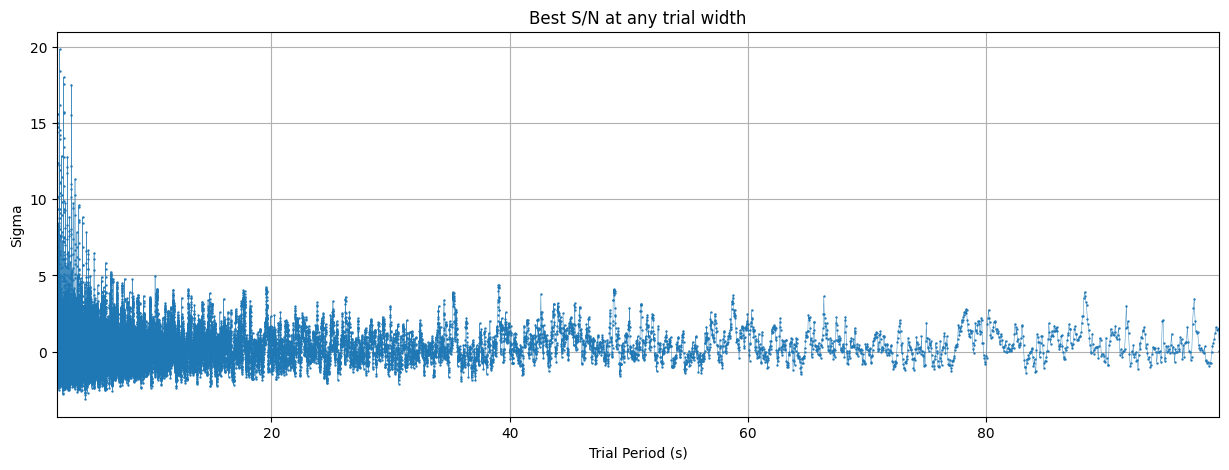

In [137]:
import riptide
import os
import matplotlib.pyplot as plt
import numpy as np
import sps_common.barycenter as barycenter
from datetime import datetime, timezone
import h5py

def date_to_mjd(date_str):
    # Parse the date string into a datetime object
    date = datetime.strptime(date_str, "%Y-%m-%d")
    
    # Convert to Julian Date (JD)
    julian_date = date.toordinal() + 1721424.5
    
    # Convert JD to Modified Julian Date (MJD)
    mjd = julian_date - 2400000.5
    
    return mjd

def rate_periodogram(peaks, dm, birdies):
    if len(peaks) == 0 or dm < 2:
        return 0
    main_peak = peaks[0]

    tolerance = 0.01
    # Zap if main peak is one of the first 10 harmonics of a birdie
    for birdie in birdies:
        for harmonic_order in range(1,11):
            harmonic_period = birdie*harmonic_order
            if abs(main_peak.period - harmonic_period)/harmonic_period < tolerance:
                return 0
        
    
    # Add first 10 harmonics of the main peak with a weight
    tolerance = 0.01
    rating = main_peak.snr
    for harmonic_order in range(2,10):
        harmonic_period = main_peak.period * harmonic_order
        harmonic_peaks = list(filter(lambda peak: abs(peak.period-harmonic_period)/harmonic_period < tolerance, peaks))
        if harmonic_peaks:
            rating += harmonic_peaks[0].snr / 2
    return rating

ra = 29.37
dec = 62.12

directory = f"/scratch/ltarabout/FFA_search_CHIMEPulsar_test/stack_{ra}_{dec}"
file_path = f"/scratch/ltarabout/FFA_search_CHIMEPulsar_test/stack_{ra}_{dec}/stack_{ra}_{dec}.hdf5"

best_rating = -1000
best_pgram = None
best_peak = None
best_dm = None
birdies = [1/1.5625]
pgram_0 = None
peaks_0 = None
pgram_close0 = None
peaks_close0 = None


with h5py.File(file_path, 'r') as hf:
    snrs = hf["snrs"][:]
    periods = hf["periods"][:]
    dm = hf.attrs["dm"]
    widths = hf.attrs["widths"]
    foldbins = hf["foldbins"][:]
    stack_length = hf.attrs["stack_length"]

print("N period trials:", len(periods))
print("Boxcar width trials:",widths)
print("Stack length:",stack_length)

pgram = riptide.Periodogram(widths, periods, foldbins, snrs, {})
pgram.metadata['dm'] = dm

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(pgram.periods, pgram.snrs.max(axis=1),linewidth=0.3, marker='o', markersize=0.7)
plt.title("Best S/N at any trial width")
plt.xlim(min(pgram.periods),max(pgram.periods))
plt.xlabel("Trial Period (s)")
plt.ylabel("Sigma")
# plt.xticks(np.arange(min(pgram.periods),max(pgram.periods),2))
# plt.yticks(np.arange(-10,max(pgram.snrs.max(axis=1)),5))
plt.grid(True)
# plt.xlim(82,84)

In [143]:
import riptide
import os
import matplotlib.pyplot as plt
import numpy as np
import sps_common.barycenter as barycenter
from datetime import datetime, timezone
import h5py

def date_to_mjd(date_str):
    # Parse the date string into a datetime object
    date = datetime.strptime(date_str, "%Y-%m-%d")
    
    # Convert to Julian Date (JD)
    julian_date = date.toordinal() + 1721424.5
    
    # Convert JD to Modified Julian Date (MJD)
    mjd = julian_date - 2400000.5
    
    return mjd

def rate_periodogram(peaks, dm, birdies):
    if len(peaks) == 0 or dm < 2:
        return 0
    main_peak = peaks[0]

    tolerance = 0.01
    # Zap if main peak is one of the first 10 harmonics of a birdie
    for birdie in birdies:
        for harmonic_order in range(1,11):
            harmonic_period = birdie*harmonic_order
            if abs(main_peak.period - harmonic_period)/harmonic_period < tolerance:
                return 0
        
    
    # Add first 10 harmonics of the main peak with a weight
    tolerance = 0.01
    rating = main_peak.snr
    for harmonic_order in range(2,10):
        harmonic_period = main_peak.period * harmonic_order
        harmonic_peaks = list(filter(lambda peak: abs(peak.period-harmonic_period)/harmonic_period < tolerance, peaks))
        if harmonic_peaks:
            rating += harmonic_peaks[0].snr / 2
    return rating

ra = 29.37
dec = 62.12
# ra = 114.34
# dec = 69.14
# ra = 90.11
# dec = 50.1
# ra = 105.95
# dec = 50.52
# ra = 301.12
# dec = 31.53
# ra = 160.01
# dec = 50.21

directory = f"/scratch/ltarabout/stack_{ra}_{dec}"
file_path = f"/scratch/ltarabout/stack_{ra}_{dec}/stack_{ra}_{dec}.hdf5"

best_rating = -1000
best_pgram = None
best_peak = None
best_dm = None
birdies = [1/1.5625]
pgram_0 = None
peaks_0 = None
pgram_close0 = None
peaks_close0 = None


with h5py.File(file_path, 'r') as hf:
    snrs = hf["snrs"][:][:]
    periods = hf["periods"][:]
    dms = hf["dms"][:]
    widths = hf.attrs["widths"]
    foldbins = hf["foldbins"][:]
    stack_length = hf.attrs["stack_length"]

n_dm_trials = len(dms)
peaks_array = []
print("N dm trials:", n_dm_trials)
print("N period trials:", len(periods))
print(widths)
print(stack_length)


N dm trials: 553
N period trials: 76994
[1 2 3 4 6 9]
9


Best dm: 29.9545881997123


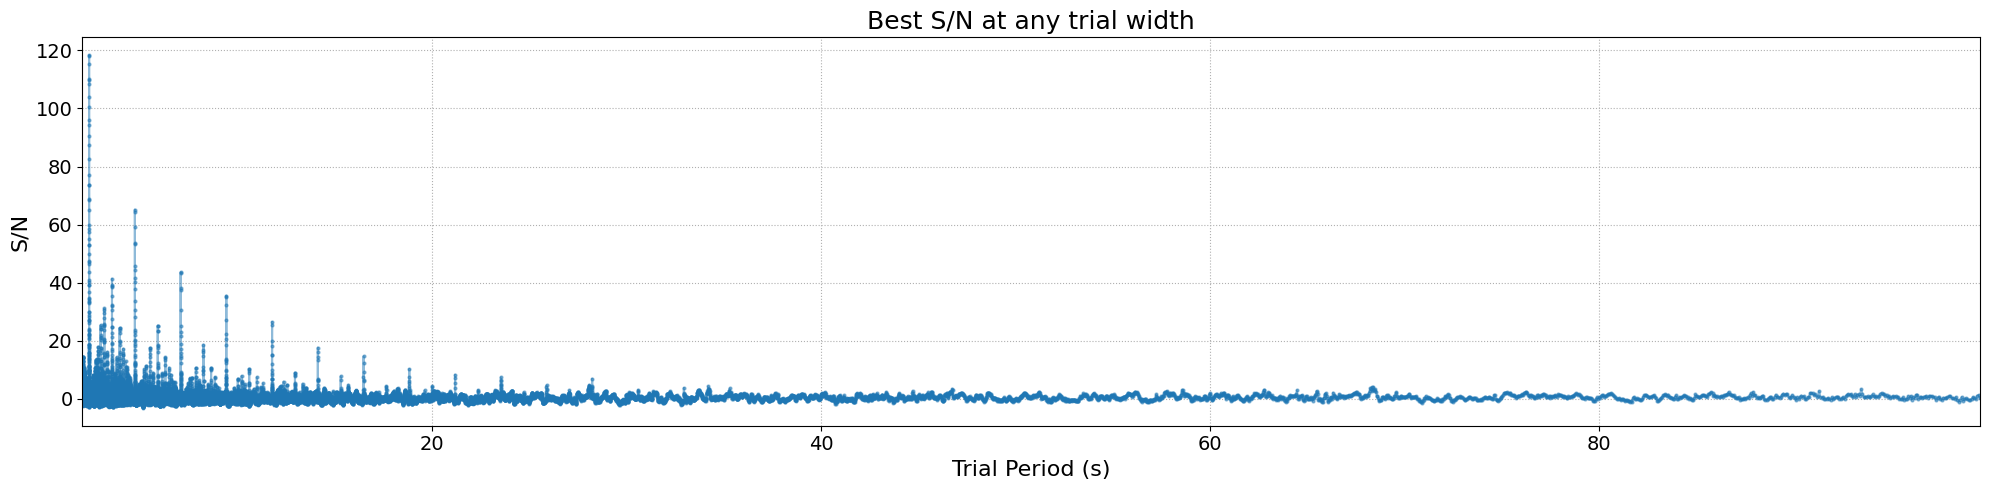

In [144]:
for dm_trial in range(n_dm_trials):
    dm = dms[dm_trial]
    stack_snrs = snrs[dm_trial]
    stack_pgram = riptide.Periodogram(widths, periods, foldbins, stack_snrs, {})
    stack_pgram.metadata['dm'] = dm
    stack_pgram.metadata['tobs'] = 796.6

    
    # peak_file_path = os.path.join(directory,f"peak_track_{ra}_{dec}_{dm}.json")
    #peak_track = riptide.load_json(peak_file_path)
    
    peaks, __ = riptide.find_peaks(stack_pgram, smin=6, nstd=0)
    peaks_array.append(peaks)
    rating = rate_periodogram(peaks,float(dm),birdies)*stack_length

    if rating > best_rating:
        best_pgram = stack_pgram
        best_rating = rating
        if len(peaks) > 0:
            best_peak = peaks
        best_dm = dm

    if dm == 0:
        pgram_0 = stack_pgram
        peaks_0 = peaks

    if dm > 0 and dm < 1:
        pgram_close0 = stack_pgram
        peaks_close0 = peaks
        
print("Best dm:", best_dm)
# print("Best_peak", best_peak)
best_pgram.display()


def square_root(x,a):
    return a*np.sqrt(x)
    
best_snrs = [41.002, 52.898, 73.820, 84.014, 92.984, 105.935, 109.941]
stack_length = [1,2,3,4,5,6,7]
# plt.plot(stack_length, best_snrs)

In [203]:
detections_dtype = [
    ("dm", float),
    ("freq", float),
    ("sigma", float),
    ("width", int)
]
    
detections = np.array([(
    dms[dm_trial],
    1/peak.period,
    peak.snr,
    peak.width
) for dm_trial in range(n_dm_trials) for peak in peaks_array[dm_trial]], dtype = detections_dtype)
print(len(detections))

10155


Best dm: 234.77920480855585
Best_peak Peak(period=2.111086845745068, freq=0.4736896551724138, width=2, ducy=0.01, iw=1, ip=2190, snr=152.67115783691406, dm=234.77920480855585)


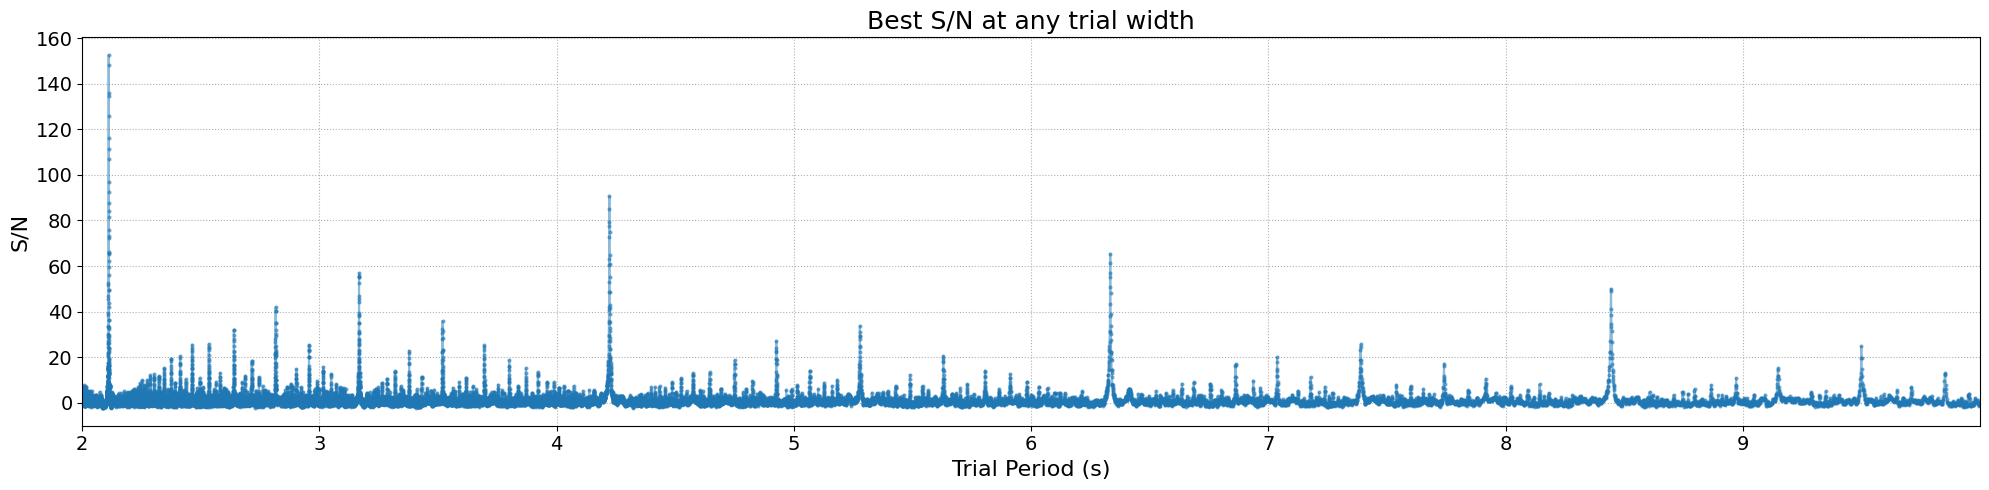

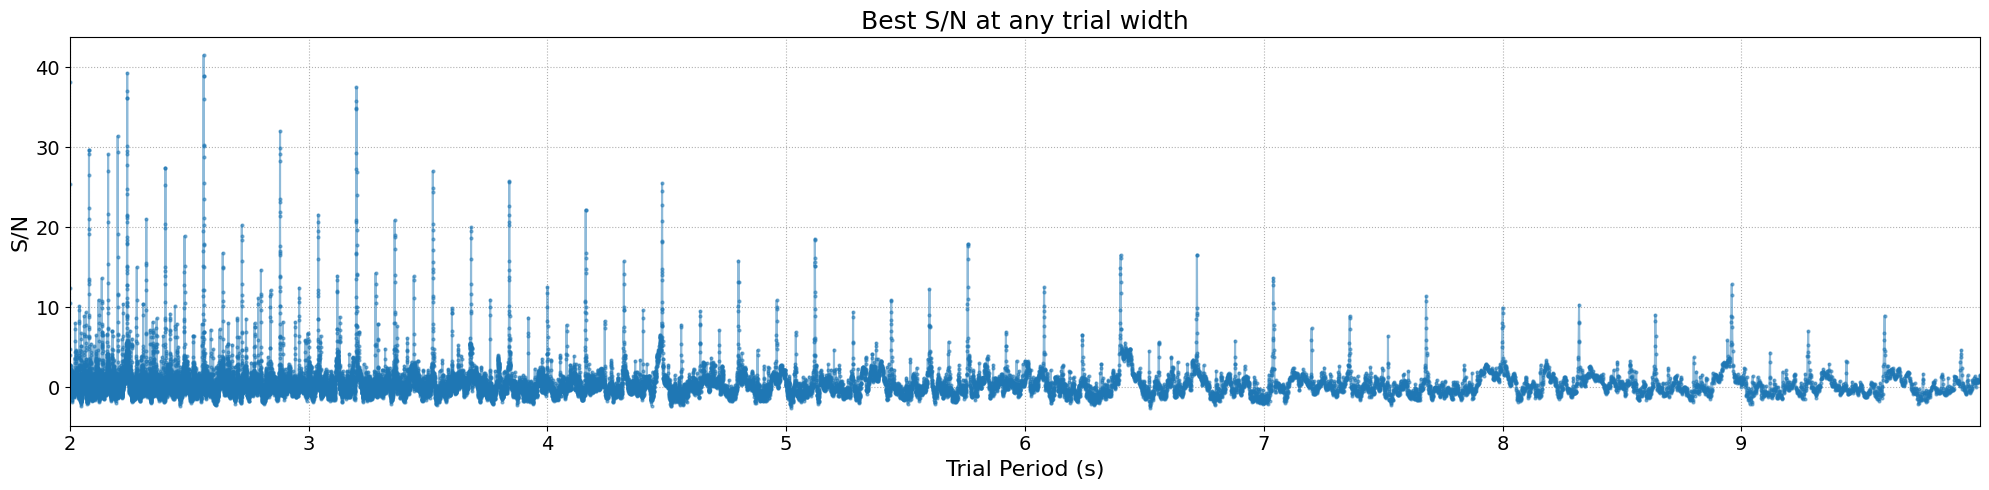

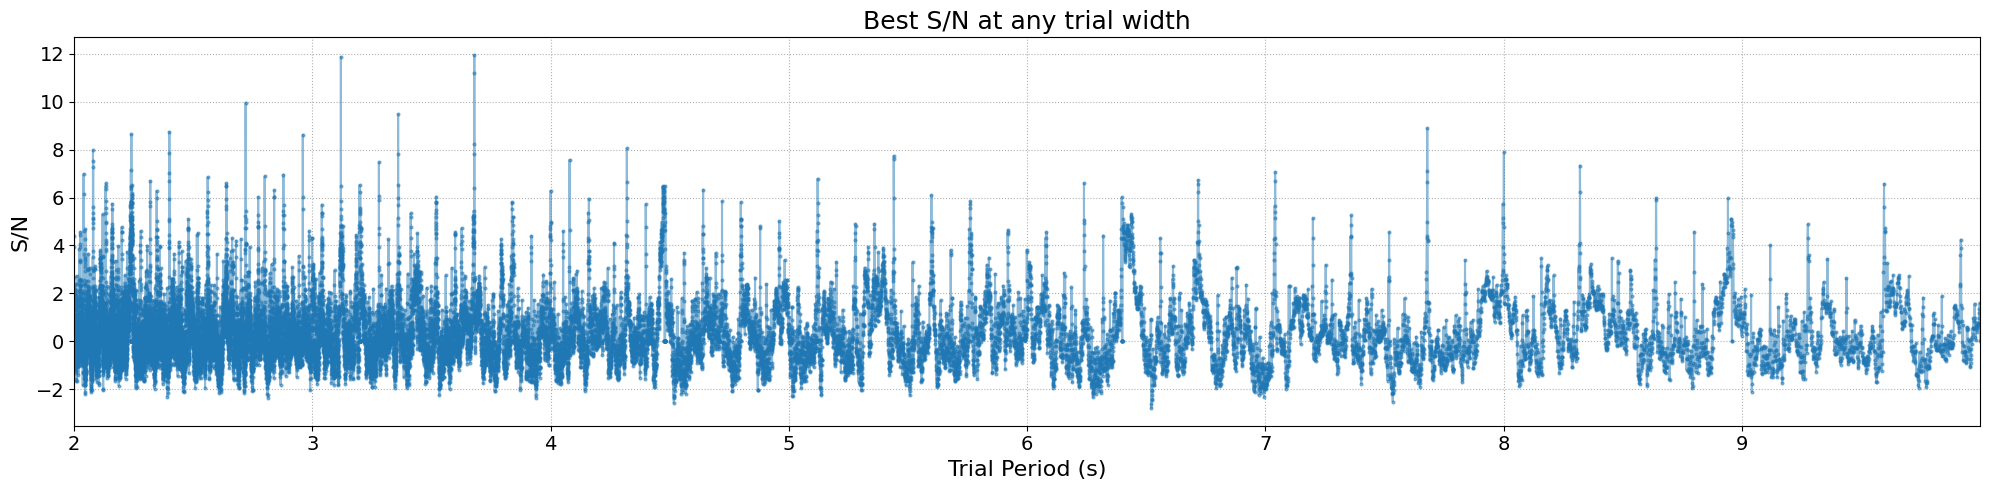

[Peak(period=2.5599776633054994, freq=0.39062840833883605, width=2, ducy=0.01015228426395939, iw=1, ip=9318, snr=41.55549240112305, dm=0.0), Peak(period=2.239987758096016, freq=0.44643101123463175, width=2, ducy=0.010471204188481676, iw=1, ip=4564, snr=39.32155990600586, dm=0.0), Peak(period=2.5599776633054994, freq=0.39062840833883605, width=1, ducy=0.005076142131979695, iw=0, ip=9318, snr=38.5877685546875, dm=0.0), Peak(period=2.0, freq=0.5, width=1, ducy=0.005263157894736842, iw=0, ip=0, snr=38.13349914550781, dm=0.0), Peak(period=3.2001545605011033, freq=0.31248490693006176, width=1, ducy=0.005025125628140704, iw=0, ip=16007, snr=37.52714538574219, dm=0.0), Peak(period=3.2002751072506617, freq=0.3124731363670464, width=2, ducy=0.010050251256281407, iw=1, ip=16008, snr=35.802005767822266, dm=0.0), Peak(period=2.239987758096016, freq=0.44643101123463175, width=3, ducy=0.015706806282722512, iw=2, ip=4564, snr=35.63546371459961, dm=0.0), Peak(period=2.2401109663553105, freq=0.446406457

(2.23, 2.25)

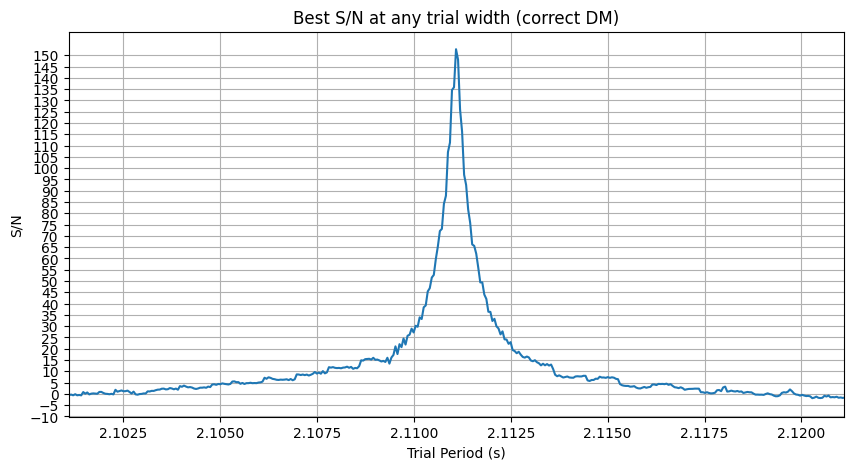

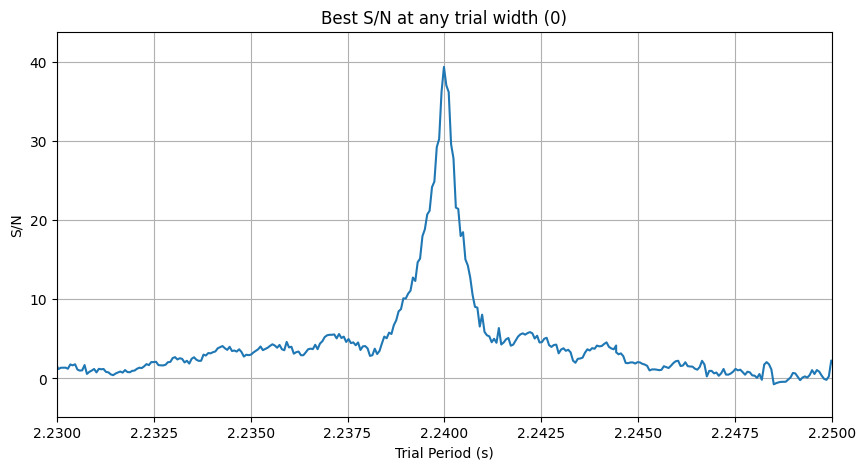

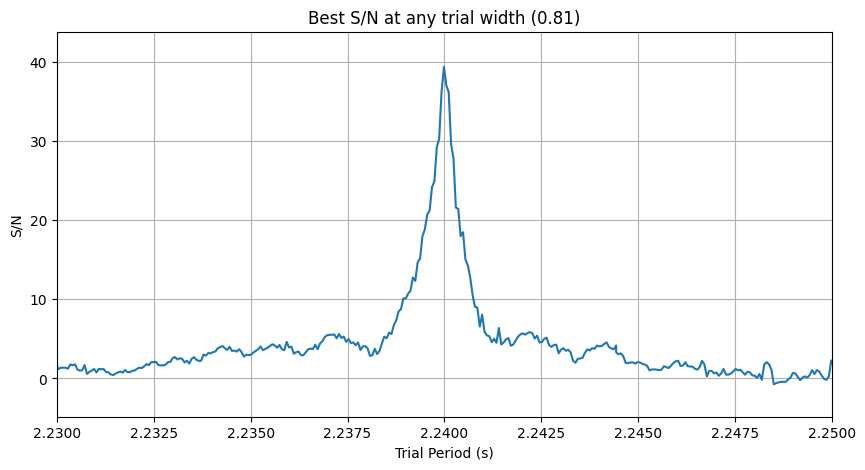

In [7]:
print("Best dm:", best_dm)
print("Best_peak", best_peak)
best_pgram.display()
pgram_0.display()
pgram_close0.display()

print(peaks_0)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(best_pgram.periods, best_pgram.snrs.max(axis=1))
plt.title("Best S/N at any trial width (correct DM)")
plt.xlabel("Trial Period (s)")
plt.ylabel("S/N")
# plt.xticks(np.arange(min(best_pgram.periods),max(best_pgram.periods),2))
plt.yticks(np.arange(-10,max(best_pgram.snrs.max(axis=1)),5))
plt.grid(True)
plt.xlim(best_peak.period-0.01,best_peak.period+0.01)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(best_pgram.periods, pgram_0.snrs.max(axis=1))
plt.title("Best S/N at any trial width (0)")
plt.xlabel("Trial Period (s)")
plt.ylabel("S/N")
# plt.xticks(np.arange(min(best_pgram.periods),max(best_pgram.periods),2))
# plt.yticks(np.arange(-10,max(best_pgram.snrs.max(axis=1)),5))
plt.grid(True)
plt.xlim(2.23,2.25)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(best_pgram.periods, pgram_0.snrs.max(axis=1))
plt.title("Best S/N at any trial width (0.81)")
plt.xlabel("Trial Period (s)")
plt.ylabel("S/N")
# plt.xticks(np.arange(min(best_pgram.periods),max(best_pgram.periods),2))
# plt.yticks(np.arange(-10,max(best_pgram.snrs.max(axis=1)),5))
plt.grid(True)
plt.xlim(2.23,2.25)

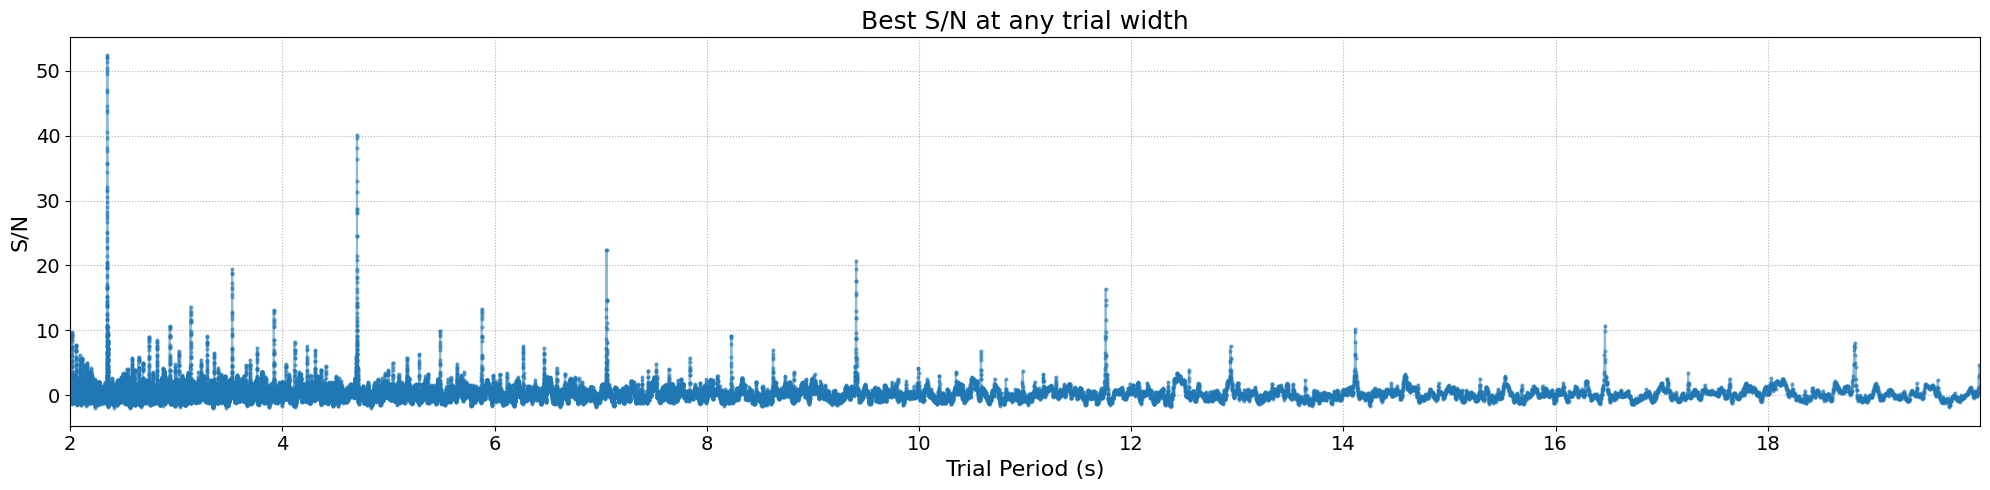

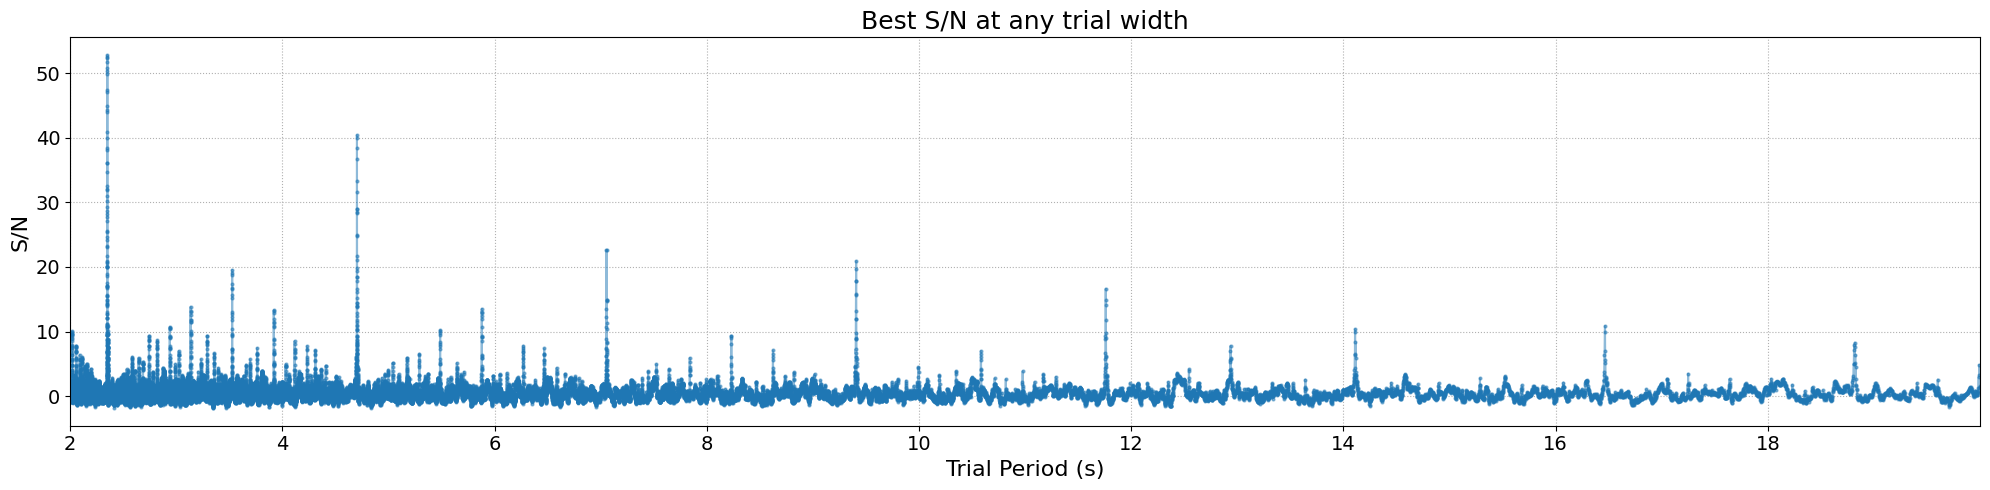

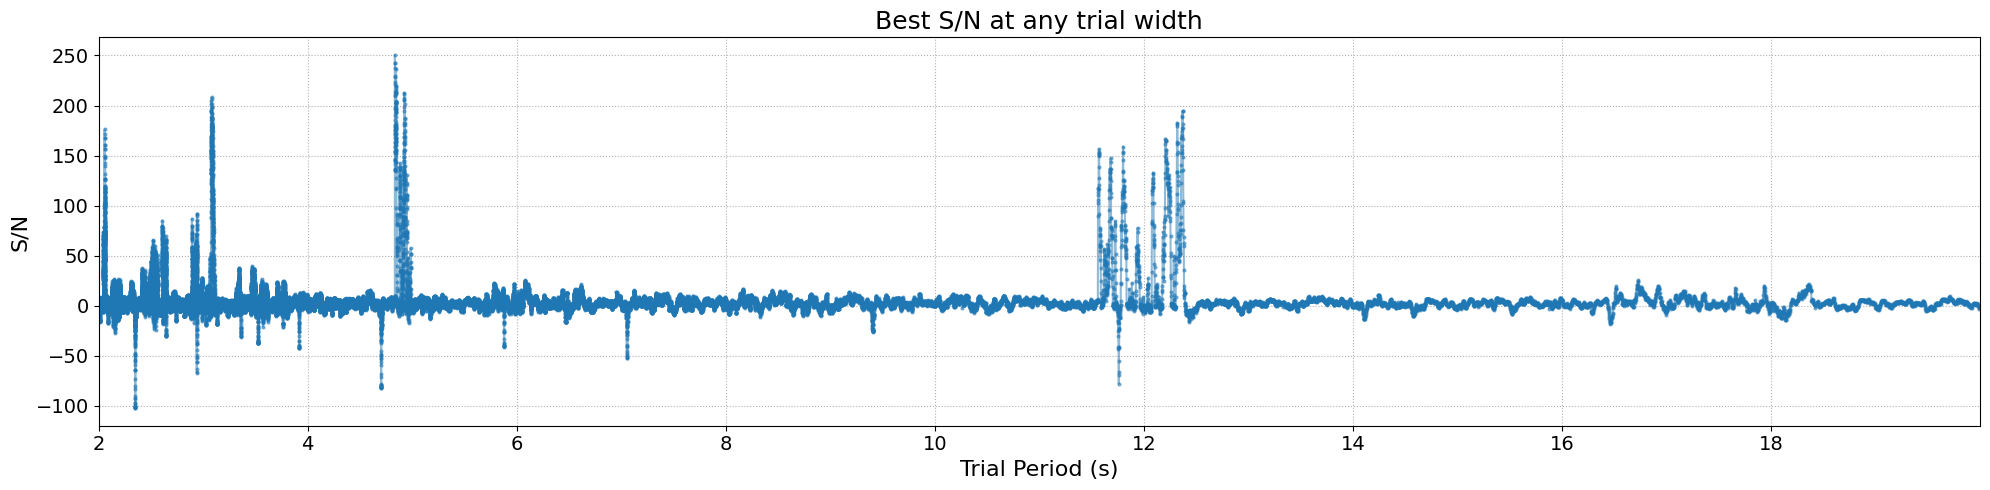

In [11]:
from scipy.signal import medfilt
import time
import copy

def remove_baseline_minus(pgram):
    pgram_len = len(pgram.periods)
    b0 = 50
    bmax = 1000
    sections = [0]
    section_end = 0
    for n in range(0, pgram_len):
        # create the log range for normalisation
        new_window = np.exp(1 + n / 3) * b0 / np.exp(1)
        if new_window > bmax:
            section_end += bmax
        else:
            section_end += int(new_window)
        sections.append(section_end)
        if section_end > pgram_len:
            sections[-1] = pgram_len
            break
    #print(sections)

    for iw, width in enumerate(pgram.widths):
        s = pgram.snrs[:, iw].astype(float)

        for i in range(len(sections)-1):
            s[sections[i]:sections[i+1]] -= np.median(s[sections[i]:sections[i+1]])
        pgram.snrs[:, iw] = s
    min_value = min(pgram.snrs.max(axis=1))
    #pgram.snrs -= min_value
    return pgram

def remove_baseline_divide(pgram):
    pgram_len = len(pgram.periods)
    b0 = 50
    bmax = 1000
    sections = [0]
    section_end = 0
    for n in range(0, pgram_len):
        # create the log range for normalisation
        new_window = np.exp(1 + n / 3) * b0 / np.exp(1)
        if new_window > bmax:
            section_end += bmax
        else:
            section_end += int(new_window)
        sections.append(section_end)
        if section_end > pgram_len:
            sections[-1] = pgram_len
            break
    #print(sections)

    for iw, width in enumerate(pgram.widths):
        s = pgram.snrs[:, iw].astype(float)

        for i in range(len(sections)-1):
            s[sections[i]:sections[i+1]] /= np.median(s[sections[i]:sections[i+1]])
        pgram.snrs[:, iw] = s
    return pgram


best_pgram.display()
minused_copy = copy.deepcopy(best_pgram)
remove_baseline_minus(minused_copy).display()
divided_copy = copy.deepcopy(best_pgram)
remove_baseline_divide(divided_copy).display()

NameError: name 'minused_copy' is not defined

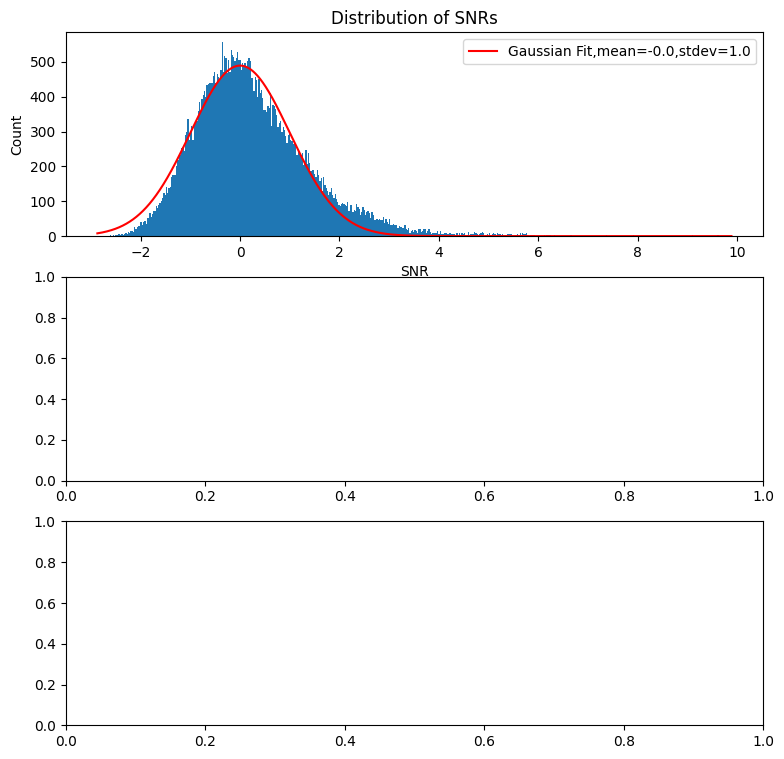

In [33]:
def gaussian_model(x, a, mu, sigma):
    return a * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))


from scipy.optimize import curve_fit

fig, axs = plt.subplots(3, 1, figsize=(9, 9))

cur_pgram = best_pgram

snr_distrib = np.histogram(cur_pgram.snrs.max(axis=1), bins=500)
popt, pcov = curve_fit(gaussian_model, snr_distrib[1][:-1], snr_distrib[0],p0=[500,1,3])
perr = np.sqrt(np.diag(pcov))

x = np.linspace(min(snr_distrib[1]), max(snr_distrib[1]), 10000)
axs[0].plot(x, gaussian_model(x, *popt), 'r-', label='Gaussian Fit,mean='+str(np.round(popt[1],2))+',stdev='+str(np.round(popt[2],2)))

axs[0].hist(cur_pgram.snrs.max(axis=1), bins=500)
axs[0].set_title("Distribution of SNRs")
axs[0].set_ylabel("Count")
axs[0].set_xlabel("SNR")
axs[0].legend()



cur_pgram = minused_copy

snr_distrib = np.histogram(cur_pgram.snrs.max(axis=1), bins=500)
popt, pcov = curve_fit(gaussian_model, snr_distrib[1][:-1], snr_distrib[0],p0=[500,1,3])
perr = np.sqrt(np.diag(pcov))

x = np.linspace(min(snr_distrib[1]), max(snr_distrib[1]), 10000)
axs[1].plot(x, gaussian_model(x, *popt), 'r-', label='Gaussian Fit,mean='+str(np.round(popt[1],2))+',stdev='+str(np.round(popt[2],2)))

axs[1].hist(cur_pgram.snrs.max(axis=1), bins=500)
axs[1].set_title("Distribution of SNRs")
axs[1].set_ylabel("Count")
axs[1].set_xlabel("SNR")
axs[1].legend()

cur_pgram = divided_copy

snr_distrib = np.histogram(cur_pgram.snrs.max(axis=1), bins=500)
# popt, pcov = curve_fit(gaussian_model, snr_distrib[1][:-1], snr_distrib[0],p0=[5000,1,0.1])
popt, pcov = curve_fit(gaussian_model, snr_distrib[1][:-1], snr_distrib[0],p0=[5000,1,0.1],bounds=([0,0,0],[np.inf,np.inf,np.inf]))
perr = np.sqrt(np.diag(pcov))

x = np.linspace(min(snr_distrib[1]), max(snr_distrib[1]), 10000)
axs[2].plot(x, gaussian_model(x, *popt), 'r-', label='Gaussian Fit,mean='+str(np.round(popt[1],2))+',stdev='+str(np.round(popt[2],2)))

axs[2].hist(cur_pgram.snrs.max(axis=1), bins=500)
axs[2].set_title("Distribution of SNRs")
axs[2].set_ylabel("Count")
axs[2].set_xlabel("SNR")
axs[2].legend()

plt.tight_layout()
plt.show()

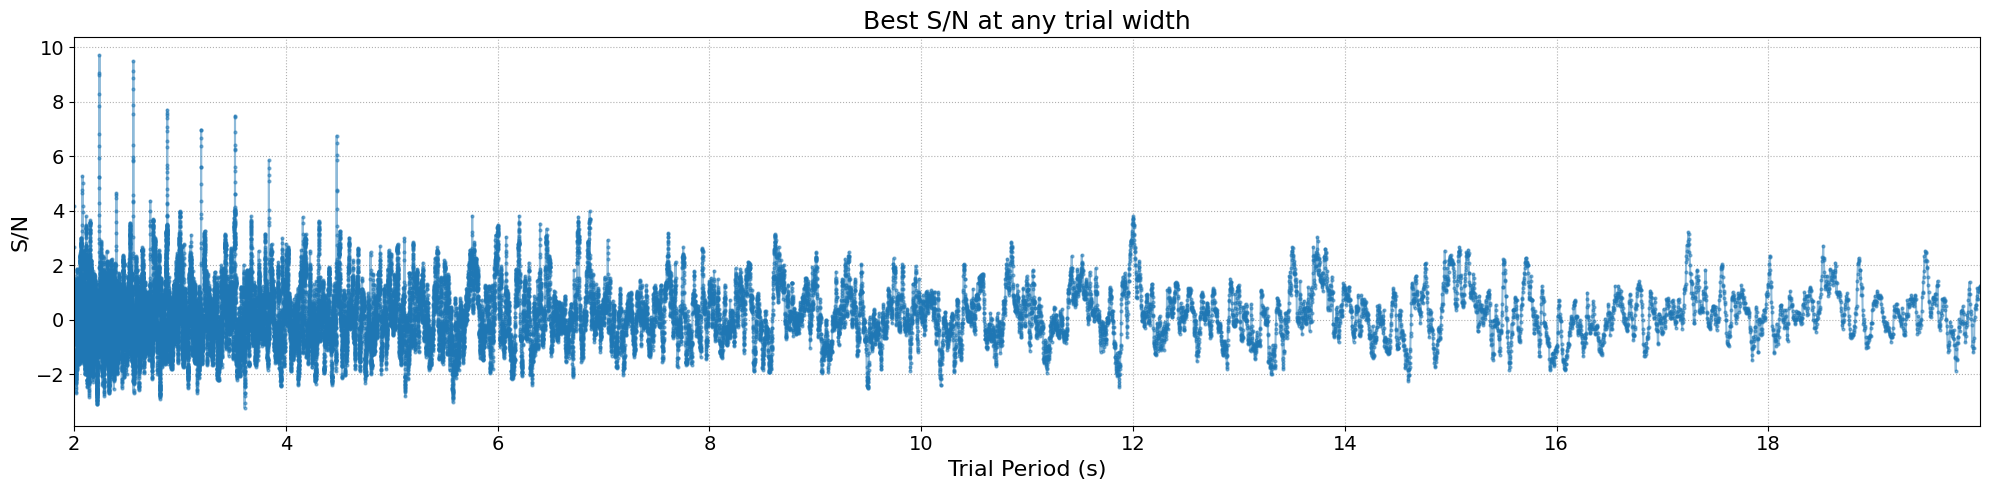

[Peak(period=2.239948423373597, freq=0.4464388508079553, width=1, ducy=0.005235602094240838, iw=0, ip=5937, snr=9.712200164794922, dm='89.05'), Peak(period=2.56004478804065, freq=0.39061816600691496, width=1, ducy=0.005076142131979695, iw=0, ip=12105, snr=9.4923095703125, dm='89.05'), Peak(period=2.2399956746851335, freq=0.4464294334588685, width=2, ducy=0.010471204188481676, iw=1, ip=5938, snr=9.038366317749023, dm='89.05'), Peak(period=2.559984842253453, freq=0.39062731290226693, width=2, ducy=0.01015228426395939, iw=1, ip=12104, snr=8.890202522277832, dm='89.05'), Peak(period=2.56004478804065, freq=0.39061816600691496, width=3, ducy=0.015228426395939087, iw=2, ip=12105, snr=8.134878158569336, dm='89.05'), Peak(period=2.239948423373597, freq=0.4464388508079553, width=3, ducy=0.015706806282722512, iw=2, ip=5937, snr=7.7611494064331055, dm='89.05'), Peak(period=2.879944678611699, freq=0.3472288920779056, width=2, ducy=0.010050251256281407, iw=1, ip=16931, snr=7.709875583648682, dm='89.

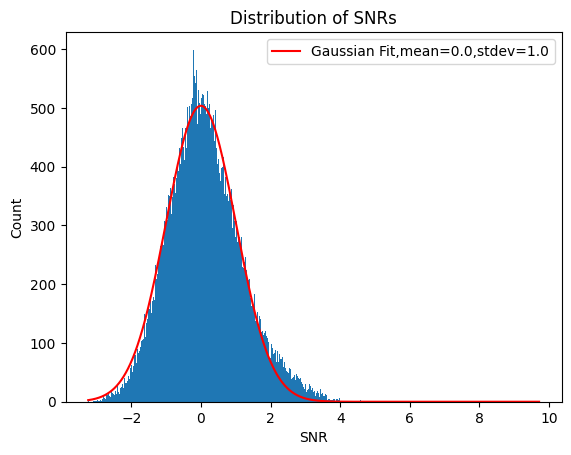

In [7]:
standardized_copy = copy.deepcopy(divided_copy)
standardized_copy.snrs -= popt[1]
standardized_copy.snrs /= popt[2]
standardized_copy.display()

cur_pgram = standardized_copy

snr_distrib = np.histogram(cur_pgram.snrs.max(axis=1), bins=500)
popt, pcov = curve_fit(gaussian_model, snr_distrib[1][:-1], snr_distrib[0],p0=[500,1,3])
perr = np.sqrt(np.diag(pcov))

x = np.linspace(min(snr_distrib[1]), max(snr_distrib[1]), 10000)
plt.plot(x, gaussian_model(x, *popt), 'r-', label='Gaussian Fit,mean='+str(np.round(popt[1],2))+',stdev='+str(np.round(popt[2],2)))

plt.hist(cur_pgram.snrs.max(axis=1), bins=500)
plt.title("Distribution of SNRs")
plt.ylabel("Count")
plt.xlabel("SNR")
plt.legend()



Best peaks: Peak(period=2.351890071048042, freq=0.4251899407672498, width=3, ducy=0.014925373134328358, iw=2, ip=11782, snr=46.3459358215332, dm='62.12')
Best DM: 62.12
Rating: 300.9293324947357
Fit parameters [2.35188802e+00 6.43369239e-04 4.12977690e+01]
Standard errors [5.85370853e-06 8.27978714e-06 3.75758059e-01]


(2.3418900710480424, 2.361890071048042)

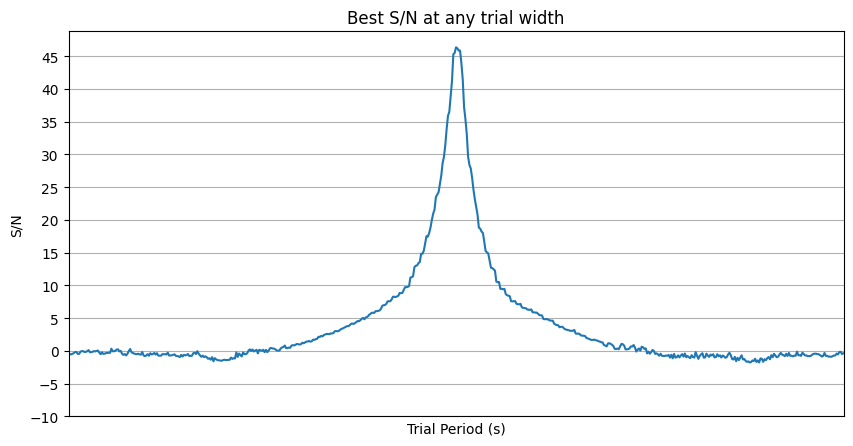

In [15]:
from scipy.optimize import curve_fit
# Define the Lorentzian function
def lorentzian(x, x0, gamma, a):
    return a * (gamma**2 / ((x - x0)**2 + gamma**2))

mask = (best_pgram.periods >= best_peak.period-0.01) & (best_pgram.periods <= best_peak.period+0.01)
periods_section = best_pgram.periods[mask]
snrs_section = best_pgram.snrs.max(axis=1)[mask]

# Fit the Lorentzian curve to the selected data
popt, pcov = curve_fit(lorentzian, periods_section, snrs_section, p0=[best_peak.period, 0.01, best_peak.snr])
perr = np.sqrt(np.diag(pcov))

print("Best peaks:",best_peak)
print("Best DM:", best_dm)
print("Rating:",best_rating)
print("Fit parameters",popt)
print("Standard errors", perr)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(best_pgram.periods, best_pgram.snrs.max(axis=1))
plt.title("Best S/N at any trial width")
plt.xlabel("Trial Period (s)")
plt.ylabel("S/N")
plt.xticks(np.arange(min(best_pgram.periods),max(best_pgram.periods),2))
plt.yticks(np.arange(-10,max(best_pgram.snrs.max(axis=1)),5))
plt.grid(True)
plt.xlim(best_peak.period-0.01,best_peak.period+0.01)

In [81]:
file_path = os.path.join(directory,f"peak_track_{ra}_{dec}_{best_dm}.json")

peak_track = riptide.load_json(file_path)
mjd_dates = [item["mjd"] for item in peak_track]
periods = [item["period"] for item in peak_track]
fit_params = [item["fit params"] for item in peak_track]
fit_errors = [item["fit errors"] for item in peak_track]
cleaned_periods, cleaned_dates, cleaned_fit_params, cleaned_fit_errors = [], [], [], []
for i in range(len(periods)):
    if periods[i] is not None:
        cleaned_dates.append(mjd_dates[i])
        cleaned_periods.append(periods[i])
        cleaned_fit_params.append(fit_params[i])
        cleaned_fit_errors.append(fit_errors[i])
mjd_dates = cleaned_dates
periods = cleaned_periods
fit_params = cleaned_fit_params
fit_errors = cleaned_fit_errors
print(mjd_dates,periods, fit_params)

[60462.715104166666, 60463.712372685186, 60464.709641203706, 60465.70690972222, 60466.70417824074, 60467.70145833334, 60468.69872685185, 60469.69599537037] [2.351890071048042, 2.3518554202234108, 2.3518207704197978, 2.3518207704197978, 2.3518207704197978, 2.3518554202234108, 2.3518554202234108, 2.351890071048042] [array([2.35188033e+00, 3.80004797e-04, 4.28863426e+01]), array([2.35189164e+00, 3.93707513e-04, 4.10655801e+01]), array([ 2.35186610e+00, -3.99033736e-04,  4.96627454e+01]), array([2.35186685e+00, 2.96594458e-04, 4.40655709e+01]), array([ 2.35186880e+00, -2.83365180e-04,  4.17316441e+01]), array([2.35185822e+00, 3.16144614e-04, 5.53043997e+01]), array([ 2.35187261e+00, -2.79941644e-04,  3.50770315e+01]), array([ 2.35187425e+00, -4.73273922e-04,  7.19403735e+01])]


In [82]:
#topo_freqs = [1/fit_params[i][0] for i in range(len(fit_params))]
topo_freqs = [1/periods[i] for i in range(len(periods))]

# Error in period is 0.00005s approx
topo_freqs_error = [topo_freqs[i]*fit_errors[i][0]/fit_params[i][0] for i in range(len(topo_freqs))]

bary_freqs = []
bary_freqs_error = []
tobs = periods_bins["metadata"]["tobs"]
for index in range(len(mjd_dates)):
    beta = barycenter.get_mean_barycentric_correction(str(ra),str(dec),mjd_dates[index],tobs)
    bary_freq = barycenter.bary_from_topo_freq(topo_freqs[index],beta)
    bary_freqs.append(bary_freq)
    bary_freqs_error.append(topo_freqs_error[index])


[2024-08-26 13:26:50,254] INFO::barycenter: RA (J2000) : 5h22m12s
[2024-08-26 13:26:50,256] INFO::barycenter: Dec (J2000) : 62d07m12s
[2024-08-26 13:26:50,256] INFO::barycenter: Topocentric MJD : 60462.715104166666 - 60462.72432417164
[2024-08-26 13:26:50,794] INFO::barycenter: mean barycentric velocity (fraction of speed of light) = -1.7470615956305394e-05
[2024-08-26 13:26:50,796] INFO::barycenter: RA (J2000) : 5h22m12s
[2024-08-26 13:26:50,797] INFO::barycenter: Dec (J2000) : 62d07m12s
[2024-08-26 13:26:50,798] INFO::barycenter: Topocentric MJD : 60463.712372685186 - 60463.72159269016
[2024-08-26 13:26:51,335] INFO::barycenter: mean barycentric velocity (fraction of speed of light) = -1.620825486452926e-05
[2024-08-26 13:26:51,337] INFO::barycenter: RA (J2000) : 5h22m12s
[2024-08-26 13:26:51,337] INFO::barycenter: Dec (J2000) : 62d07m12s
[2024-08-26 13:26:51,338] INFO::barycenter: Topocentric MJD : 60464.709641203706 - 60464.71886120868
[2024-08-26 13:26:51,866] INFO::barycenter: me

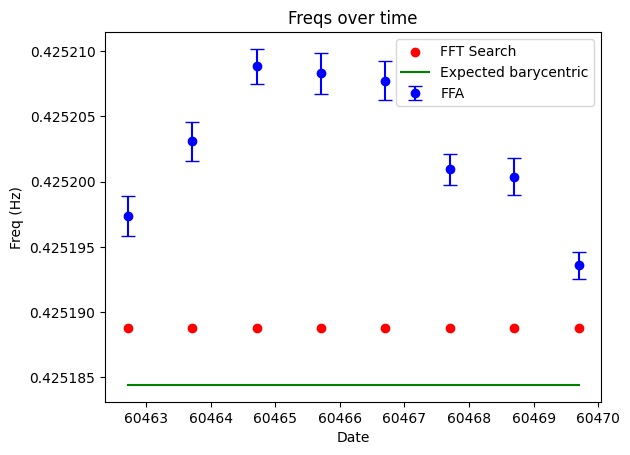

In [85]:
known_freq_B0154 = 0.4251844181
known_freq_B2002 = 0.4736342125
expected_freqs = [known_freq_B0154 for i in range(len(periods))]
#fft_freq_B0154 = [0.425188773078844,0.425188773078844,0.425188773078844,0.425188773078844,0.425188773078844, 0.425188773078844,0.425188773078844, 0.425188773078844]
fft_freq_B0154 = [0.425188773078844 for i in range(len(periods))]
fft_sigma_B0154 = [50.42,45.35,50.41,42.89,40.31,52.53,48.92,65.83]
ffa_sigma_B0154 = [52.03,51.67,58.89,51.80,47.63,62.51,42.85,83.91]


# Create the peak track plot
fig, ax = plt.subplots()
ax.errorbar(mjd_dates, bary_freqs, yerr = bary_freqs_error, fmt='o', capsize=5, label="FFA",color="blue")
ax.scatter(mjd_dates, fft_freq_B0154, label="FFT Search", color="red")
ax.plot(mjd_dates,expected_freqs, label="Expected barycentric", color="green")
plt.xlabel('Date')
#plt.xticks(ticks=dates[::16])
plt.ylabel('Freq (Hz)')
plt.title('Freqs over time')
ax.legend(loc="upper right")
plt.show()

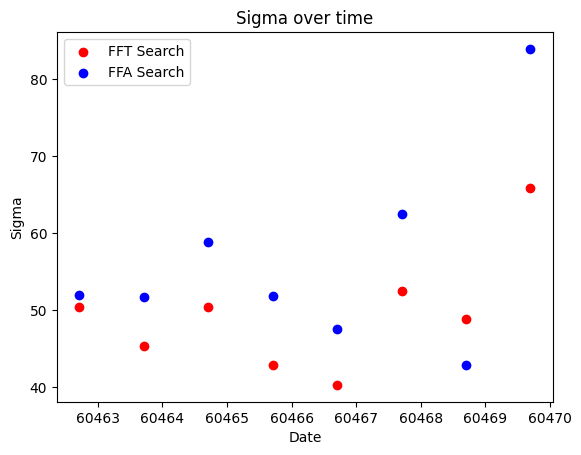

In [87]:
# Create the sigma track plot
fig, ax = plt.subplots()
ax.scatter(mjd_dates, fft_sigma_B0154, label="FFT Search", color="red")
ax.scatter(mjd_dates, ffa_sigma_B0154, label="FFA Search", color="blue")
plt.xlabel('Date')
#plt.xticks(ticks=dates[::16])
plt.ylabel('Sigma')
plt.title('Sigma over time')
ax.legend(loc="upper left")
plt.show()

In [33]:
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import astropy.units as u


# Example: Ecliptic coordinates (longitude, latitude) in degrees
ecliptic_longitude = 313.839140000000000 * u.deg
ecliptic_latitude = 50.4161469999999999995 * u.deg

# Create a SkyCoord object in ecliptic coordinates
ecliptic_coord = SkyCoord(lon=ecliptic_longitude, lat=ecliptic_latitude, frame='barycentrictrueecliptic')

# Convert to equatorial coordinates (RA, Dec)
equatorial_coord = ecliptic_coord.transform_to('icrs')

# Print the result
print(f"Right Ascension (RA): {equatorial_coord.ra}")
print(f"Declination (Dec): {equatorial_coord.dec}")

angle_in_hours = Angle("01:57:49.93365858", unit=u.hour)
angle_in_degrees = angle_in_hours.degree
print(f"Angle in degrees: {angle_in_degrees}°")

declination_angle = Angle("62:12:26.9591044", unit=u.deg)
declination_in_degrees = declination_angle.degree
print(f"Declination in decimal degrees: {declination_in_degrees}°")

Right Ascension (RA): 301.2205933096703 deg
Declination (Dec): 31.620247630829187 deg
Angle in degrees: 29.458056910749995°
Declination in decimal degrees: 62.207488640111116°


FFA_candidate_ra_29.37_dec_62.12_f_0.425_DM_32.383.json


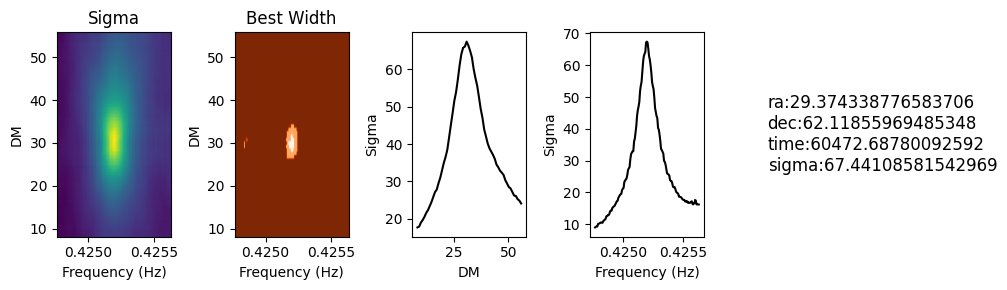

FFA_candidate_ra_29.37_dec_62.12_f_0.425_DM_29.145.json


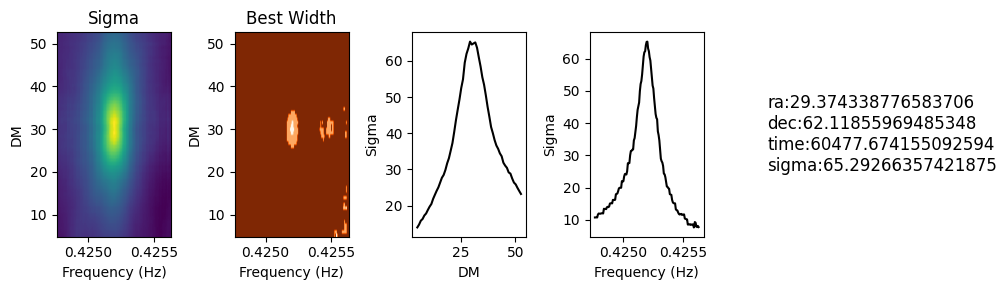

FFA_candidate_ra_32.83_dec_50.0_f_0.061_DM_7.286.npz


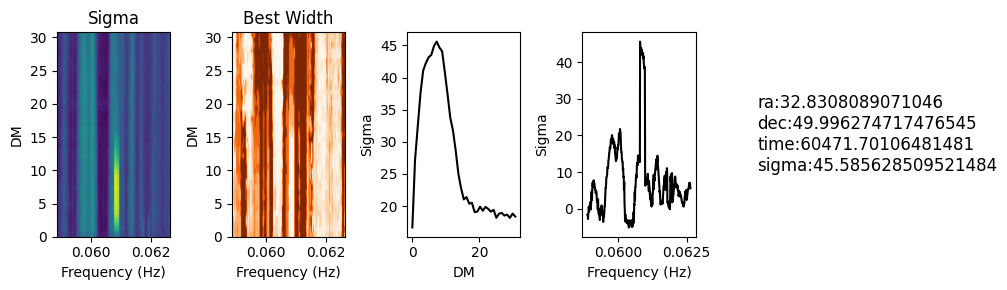

FFA_candidate_ra_29.37_dec_62.12_f_0.425_DM_30.764.json


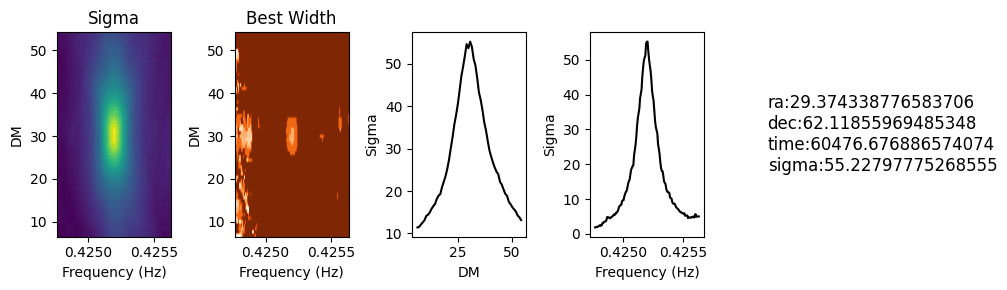

FFA_candidate_ra_29.37_dec_62.12_f_0.425_DM_31.574.json


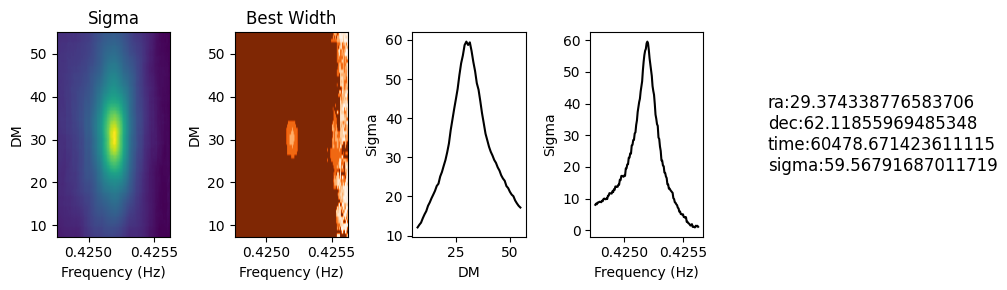

FFA_candidate_ra_29.37_dec_62.12_f_0.425_DM_29.955.json


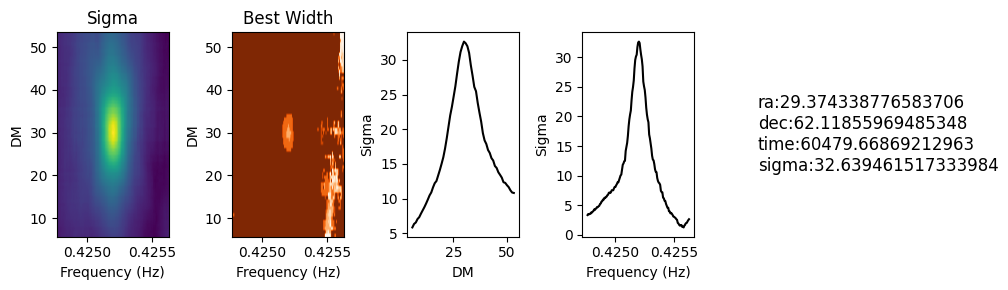

In [66]:
candidate_directory = "dailies/candidates"
file_paths = [f for f in os.listdir(candidate_directory) if (os.path.isfile(os.path.join(candidate_directory, f)))]

for file_path in file_paths:
    print(file_path)
    file_path = os.path.join(candidate_directory,file_path)
    candidate = riptide.load_json(file_path)
    freq_range = np.array(candidate["freq_range"])
    dm_range = np.array(candidate["dm_range"])
    sigma = np.array(candidate["sigma_over_dm_freq_map"])
    widths = np.array(candidate["width_over_dm_freq_map"])

    fig, axs = plt.subplots(1, 5, figsize=(10, 3), gridspec_kw={'width_ratios': [1, 1, 1, 1, 0.5]})
    axs[0].imshow(sigma, aspect='auto', cmap='viridis', origin='lower',
               extent=[freq_range.min(), freq_range.max(), dm_range.min(), dm_range.max()])
    
    axs[0].set_xlabel('Frequency (Hz)')
    axs[0].set_ylabel('DM')
    axs[0].set_title('Sigma')

    axs[1].imshow(widths, aspect='auto', cmap='Oranges', origin='lower',
               extent=[freq_range.min(), freq_range.max(), dm_range.min(), dm_range.max()])
    
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('DM')
    axs[1].set_title('Best Width')

    axs[2].plot(dm_range,sigma.max(axis=1),color="black")
    axs[2].set_xlabel('DM')
    axs[2].set_ylabel('Sigma')

    axs[3].plot(freq_range,sigma.max(axis=0),color="black")
    axs[3].set_xlabel('Frequency (Hz)')
    axs[3].set_ylabel('Sigma')

    text_info = f"ra:{candidate['ra']}\ndec:{candidate['dec']}\ntime:{candidate['time']}\nsigma:{sigma.max()}"
    axs[4].text(0, 0.5, text_info, fontsize=12, verticalalignment='center', horizontalalignment='left')
    axs[4].axis('off')

    plt.tight_layout()
    plt.show()


In [238]:
from multiday_search.fold_multiday import find_all_dates_with_data

from sps_databases import db_api
from sps_databases import db_utils

from omegaconf import OmegaConf
import logging

def apply_logging_config(level):
    """Applies logging settings from the given configuration
    Logging settings are under the 'logging' key, and include:
    - format: string for the `logging.formatter`
    - level: logging level for the root logger
    - modules: a dictionary of submodule names and logging level to be applied to that submodule's logger
    """
    log_stream.setFormatter(
        logging.Formatter(fmt="%(asctime)s %(levelname)s >> %(message)s", datefmt="%b %d %H:%M:%S")
    )    
    logging.root.setLevel(level)
    log.debug("Set default level to: %s", level)
    

log_stream = logging.StreamHandler()
logging.root.addHandler(log_stream)
log = logging.getLogger(__name__)# import in this way for easy reload  

config_file = '/home/ltarabout/FFA/sps_config_ffa.yml'
config = OmegaConf.load(config_file)

apply_logging_config('INFO')
db_utils.connect(host = 'sps-compute1', port = 27017, name = 'sps-processing')
print(find_all_dates_with_data(29.37,62.12,"/data/chime/sps/raw"))

/data/chime/sps/raw/2024/04/04 95
/data/chime/sps/raw/2024/04/05 96
/data/chime/sps/raw/2024/04/06 97
/data/chime/sps/raw/2024/04/07 97
/data/chime/sps/raw/2024/04/08 94
/data/chime/sps/raw/2024/04/09 94
/data/chime/sps/raw/2024/04/10 97
/data/chime/sps/raw/2024/04/11 95
/data/chime/sps/raw/2024/04/12 94
/data/chime/sps/raw/2024/04/13 95
['20240404', '20240405', '20240406', '20240407', '20240408', '20240409', '20240410', '20240411', '20240412', '20240413']


In [10]:
import numpy as np
data = np.load("/data/chime/sps/sps_processing/2024/06/04/43.16_51.56/43.16_51.56_0_power_spectra_candidates.npz", allow_pickle = True)
print(data.files)
for key in data.files:
    print(f"Variable name: {key}")
    array = data[key]
    print(f"Shape: {array.shape}")
    print(f"Data type: {array.dtype}")
    print(f"First few elements: {array[:1]}\n")

['candidate_dicts']
Variable name: candidate_dicts
Shape: (60,)
Data type: object
First few elements: [{'freq': 2.9991497285664086, 'dm': 8.095834648570891, 'sigma': 5.428553269037122, 'features': array([(54, 3, 59, 2, -1.38525978, 9.86191581, 0.01773327, 300, 0.77599791, 5.10557545, 3.16972015, 13.75865601, 0.01241276, 0.19546769, 0.03464508, -0.32297782, -4.9261145, 298, 0.54882122, 0.00121689, 0.05245431, 80, 0.82117164, 4.88569794, 2.99954114, 0.00172421, 0.0167959, 2.77249018e-05, 0.08929771, -0.54285533, 0.00039142, 78, 0.5055886)],
       dtype=[('num_unique_dms', '<i8'), ('num_unique_freqs', '<i8'), ('ndetections', '<i8'), ('nharm', '<i8'), ('log_p_dm', '<f8'), ('dm_sigma_FitGaussWidth_gauss_sigma', '<f8'), ('dm_sigma_FitGaussWidth_gauss_sigma_rel_err', '<f8'), ('dm_sigma_FitGaussWidth_ndof', '<i8'), ('dm_sigma_FitGaussWidth_rms_err', '<f8'), ('dm_sigma_FitGauss_amplitude', '<f8'), ('dm_sigma_FitGauss_mu', '<f8'), ('dm_sigma_FitGauss_gauss_sigma', '<f8'), ('dm_sigma_FitGauss_am

In [26]:
string = '[Peak(period=2.560008820231444, freq=0.39062365414412614, width=1, ducy=0.005076142131979695, iw=0, ip=17280, snr=16.9484920501709, dm=None), Peak(period=2.5600507827737795, freq=0.3906172513173797, width=2, ducy=0.01015228426395939, iw=1, ip=17281, snr=15.163067817687988, dm=None), Peak(period=2.240043460433193, freq=0.44641990999880604, width=1, ducy=0.005235602094240838, iw=0, ip=8477, snr=13.354960441589355, dm=None), Peak(period=2.239977173229913, freq=0.4464331208152714, width=2, ducy=0.010471204188481676, iw=1, ip=8475, snr=13.297029495239258, dm=None), Peak(period=3.2000073992707705, freq=0.31249927741663464, width=1, ducy=0.005025125628140704, iw=0, ip=29663, snr=13.097860336303711, dm=None), Peak(period=2.200029159155975, freq=0.4545394300063017, width=1, ducy=0.004784688995215311, iw=0, ip=7183, snr=12.528586387634277, dm=None), Peak(period=2.0000265150008616, freq=0.4999933713376641, width=1, ducy=0.005263157894736842, iw=0, ip=1, snr=12.455169677734375, dm=None), Peak(period=2.5600927466918, freq=0.3906108484906333, width=3, ducy=0.015228426395939087, iw=2, ip=17282, snr=11.992338180541992, dm=None), Peak(period=2.4000774426119826, freq=0.41665322220257567, width=1, ducy=0.004878048780487805, iw=0, ip=13158, snr=11.454450607299805, dm=None), Peak(period=2.880073291977644, freq=0.34721338612648134, width=1, ducy=0.005025125628140704, iw=0, ip=24160, snr=11.433093070983887, dm=None), Peak(period=2.2400103163411544, freq=0.4464265154070387, width=3, ducy=0.015706806282722512, iw=2, ip=8476, snr=11.249822616577148, dm=None), Peak(period=2.400042018160415, freq=0.41665937197486247, width=2, ducy=0.00975609756097561, iw=1, ip=13157, snr=11.135510444641113, dm=None), Peak(period=2.0799971732793736, freq=0.4807698841356481, width=2, ducy=0.01015228426395939, iw=1, ip=2955, snr=10.683492660522461, dm=None), Peak(period=2.0800801309299652, freq=0.4807507100954416, width=1, ducy=0.005076142131979695, iw=0, ip=2958, snr=10.524097442626953, dm=None), Peak(period=3.8400716421977803, freq=0.260411808209826, width=1, ducy=0.005154639175257732, iw=0, ip=37927, snr=9.486926078796387, dm=None), Peak(period=2.080024825094336, freq=0.4807634927889126, width=3, ducy=0.015228426395939087, iw=2, ip=2956, snr=9.462485313415527, dm=None), Peak(period=2.239910889949649, freq=0.4464463316317369, width=4, ducy=0.020942408376963352, iw=3, ip=8473, snr=9.119104385375977, dm=None), Peak(period=3.0400292284435504, freq=0.3289442057476484, width=1, ducy=0.004761904761904762, iw=0, ip=27126, snr=8.932793617248535, dm=None), Peak(period=3.520043482736114, freq=0.2840873997450465, width=1, ducy=0.005076142131979695, iw=0, ip=34165, snr=8.619967460632324, dm=None), Peak(period=2.0, freq=0.5, width=3, ducy=0.015789473684210527, iw=2, ip=0, snr=8.590829849243164, dm=None), Peak(period=2.1600421806855756, freq=0.4629539223547061, width=1, ducy=0.004878048780487805, iw=0, ip=5801, snr=8.482000350952148, dm=None), Peak(period=3.0400847115291914, freq=0.3289382023492992, width=2, ducy=0.009523809523809525, iw=1, ip=27127, snr=8.313620567321777, dm=None), Peak(period=2.2, freq=0.45454545454545453, width=2, ducy=0.009569377990430622, iw=1, ip=7182, snr=8.309579849243164, dm=None), Peak(period=4.479923188550042, freq=0.2232181128810061, width=1, ducy=0.004901960784313725, iw=0, ip=43813, snr=8.306204795837402, dm=None), Peak(period=2.7200550092252667, freq=0.3676396236871778, width=1, ducy=0.004784688995215311, iw=0, ip=20979, snr=7.758927822113037, dm=None), Peak(period=2.3200364590918245, freq=0.43102770910395466, width=1, ducy=0.005050505050505051, iw=0, ip=10857, snr=7.757660388946533, dm=None), Peak(period=4.000121570384527, freq=0.2499924020818875, width=1, ducy=0.0049504950495049506, iw=0, ip=39558, snr=7.547905921936035, dm=None), Peak(period=3.2001371328067827, freq=0.3124866086982085, width=4, ducy=0.020100502512562814, iw=3, ip=29665, snr=7.2739362716674805, dm=None), Peak(period=3.35999957874167, freq=0.29761908493289246, width=1, ducy=0.004784688995215311, iw=0, ip=32072, snr=7.169025421142578, dm=None), Peak(period=4.160067848949993, freq=0.2403806948130429, width=1, ducy=0.004761904761904762, iw=0, ip=41130, snr=7.085648536682129, dm=None), Peak(period=2.3999357510796906, freq=0.41667782129172287, width=4, ducy=0.01951219512195122, iw=3, ip=13154, snr=6.99202299118042, dm=None), Peak(period=3.8399753153034575, freq=0.2604183407155507, width=2, ducy=0.010309278350515464, iw=1, ip=37926, snr=6.770659923553467, dm=None), Peak(period=2.3200707016561255, freq=0.431021347446944, width=2, ducy=0.010101010101010102, iw=1, ip=10858, snr=6.654046058654785, dm=None), Peak(period=2.879968012673202, freq=0.3472260787618244, width=3, ducy=0.01507537688442211, iw=2, ip=24158, snr=6.614747524261475, dm=None), Peak(period=4.480047451370095, freq=0.22321192149296956, width=2, ducy=0.00980392156862745, iw=1, ip=43814, snr=6.429337024688721, dm=None), Peak(period=2.6400532077100127, freq=0.3787802446858266, width=1, ducy=0.0049261083743842365, iw=0, ip=19158, snr=6.300167560577393, dm=None), Peak(period=4.000021266433413, freq=0.2499986708549782, width=2, ducy=0.009900990099009901, iw=1, ip=39557, snr=6.158391952514648, dm=None), Peak(period=5.120088447443444, freq=0.19530912605607795, width=1, ducy=0.004761904761904762, iw=0, ip=48271, snr=5.914592266082764, dm=None), Peak(period=3.360067695585969, freq=0.2976130514613361, width=2, ducy=0.009569377990430622, iw=1, ip=32073, snr=5.895956993103027, dm=None), Peak(period=2.559966859064727, freq=0.39063005697087255, width=9, ducy=0.04568527918781726, iw=5, ip=17279, snr=5.8509345054626465, dm=None), Peak(period=2.480046668728208, freq=0.4032182186768323, width=1, ducy=0.005235602094240838, iw=0, ip=15343, snr=5.729980945587158, dm=None), Peak(period=4.319970118654163, freq=0.23148308264491851, width=1, ducy=0.005076142131979695, iw=0, ip=42501, snr=5.727600574493408, dm=None), Peak(period=3.4400944692072266, freq=0.2906896915044461, width=1, ducy=0.0051813471502590676, iw=0, ip=33145, snr=5.669493198394775, dm=None), Peak(period=2.2398777497805398, freq=0.4464529370399696, width=9, ducy=0.04712041884816754, iw=5, ip=8472, snr=5.606351375579834, dm=None), Peak(period=3.8398789932416673, freq=0.26042487322127544, width=3, ducy=0.015463917525773196, iw=2, ip=37925, snr=5.587320804595947, dm=None), Peak(period=3.6801203051426477, freq=0.27173024713420024, width=1, ducy=0.0048543689320388345, iw=0, ip=36140, snr=5.545503616333008, dm=None), Peak(period=2.021159775332941, freq=0.4947654372526152, width=9, ducy=0.046875, iw=5, ip=792, snr=5.476865291595459, dm=None), Peak(period=5.098690315619015, freq=0.1961287974162034, width=9, ducy=0.0430622009569378, iw=5, ip=48135, snr=5.434957027435303, dm=None), Peak(period=2.1333092248057124, freq=0.4687552973437657, width=1, ducy=0.0049504950495049506, iw=0, ip=4863, snr=5.434034824371338, dm=None), Peak(period=5.439887477648135, freq=0.1838273317433281, width=1, ducy=0.004975124378109453, iw=0, ip=50055, snr=5.356048583984375, dm=None), Peak(period=3.210061183703237, freq=0.3115205420621814, width=1, ducy=0.005, iw=0, ip=29818, snr=5.291878700256348, dm=None), Peak(period=15.009859346810131, freq=0.06662287613058268, width=1, ducy=0.005154639175257732, iw=0, ip=68510, snr=5.237902641296387, dm=None), Peak(period=2.6400099238918058, freq=0.3787864549106833, width=2, ducy=0.009852216748768473, iw=1, ip=19157, snr=5.226919174194336, dm=None), Peak(period=7.494320935315542, freq=0.1334343709898642, width=6, ducy=0.0297029702970297, iw=4, ip=58026, snr=5.171276092529297, dm=None), Peak(period=3.9999209675124634, freq=0.2500049396280688, width=3, ducy=0.01485148514851485, iw=2, ip=39556, snr=5.133049488067627, dm=None), Peak(period=2.840070912592751, freq=0.3521038842960024, width=1, ducy=0.005076142131979695, iw=0, ip=23392, snr=5.05739688873291, dm=None), Peak(period=3.120007750358369, freq=0.3205120243323557, width=1, ducy=0.005154639175257732, iw=0, ip=28412, snr=5.044441223144531, dm=None), Peak(period=2.0214008903201233, freq=0.49470642107099944, width=6, ducy=0.03125, iw=4, ip=801, snr=5.04372501373291, dm=None)]'
import re

pattern = r"period=2.3(.*)"

match = re.search(pattern, string)
if match:
    result = match.group(1)  # Everything after "freq=0.425"
    print(result)
print("Hello?")

200364590918245, freq=0.43102770910395466, width=1, ducy=0.005050505050505051, iw=0, ip=10857, snr=7.757660388946533, dm=None), Peak(period=4.000121570384527, freq=0.2499924020818875, width=1, ducy=0.0049504950495049506, iw=0, ip=39558, snr=7.547905921936035, dm=None), Peak(period=3.2001371328067827, freq=0.3124866086982085, width=4, ducy=0.020100502512562814, iw=3, ip=29665, snr=7.2739362716674805, dm=None), Peak(period=3.35999957874167, freq=0.29761908493289246, width=1, ducy=0.004784688995215311, iw=0, ip=32072, snr=7.169025421142578, dm=None), Peak(period=4.160067848949993, freq=0.2403806948130429, width=1, ducy=0.004761904761904762, iw=0, ip=41130, snr=7.085648536682129, dm=None), Peak(period=2.3999357510796906, freq=0.41667782129172287, width=4, ducy=0.01951219512195122, iw=3, ip=13154, snr=6.99202299118042, dm=None), Peak(period=3.8399753153034575, freq=0.2604183407155507, width=2, ducy=0.010309278350515464, iw=1, ip=37926, snr=6.770659923553467, dm=None), Peak(period=2.32007070

In [12]:
from riptide import TimeSeries
import numpy as np

# Generate an artificial train of pulses with a white noise background
# 600s of data, 256us sampling time, a period of pi seconds, a duty cycle of 2% and a
# true S/N of 20
tseries_fake = TimeSeries.generate(
    length=120.0, tsamp=0.001024, period=3.1, ducy=0.02, amplitude=20.0)

from riptide import ffa_search
import time

# Compute periodogram
start = time.time()
ts, pgram = ffa_search(
   tseries_fake, period_min=3, period_max=30, bins_min=240, bins_max=260, rmed_width=4.0)
print(time.time()-start)

0.02467823028564453


In [1]:
import riptide
print(riptide.__file__)

/home/ltarabout/.cache/pypoetry/virtualenvs/champss-9s7WZ3HR-py3.10/lib/python3.10/site-packages/riptide/__init__.py
